In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

In [2]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [3]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

In [5]:
ne_alps = np.copy(alps) # ne : north-east
ne_alps[lat<46.7] = False


nw_alps2 = np.copy(alps) # nw : north-west
nw_alps2[lon>7.9] = False
nw_alps2[lat<45.9] = False
nw_alps2[lat>46.7] = False

nw_alps3 = np.copy(alps) # nw : north-west
nw_alps3[lon>6.9] = False
nw_alps3[lat<44.8] = False
nw_alps3[lat>46.7] = False

nw_alps4 = np.copy(alps) # nw : north-west
nw_alps4[lon>8.3] = False
nw_alps4[lat<46.4] = False
nw_alps4[lat>46.7] = False

nw_alps5 = np.copy(alps) # nw : north-west
nw_alps5[lon>7.1] = False
nw_alps5[lat<45.2] = False
nw_alps5[lat>46.7] = False

nw_alps = np.logical_or(np.logical_or(np.logical_or(nw_alps2,nw_alps3),nw_alps4),nw_alps5)


s_alps = np.logical_and(alps,np.invert(np.logical_or(nw_alps,ne_alps)))

In [4]:
ds_T_test = xr.open_dataset('/bettik/castelli/test/ICE.EC-Earth3.EUe.TTp.01.nc')
ds_T_test

<xarray.Dataset>
Dimensions:  (time: 31, plev: 7, y: 126, x: 201)
Coordinates:
  * plev     (plev) float32 925.0 850.0 800.0 700.0 600.0 500.0 200.0
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 1979-01-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
Data variables:
    TTp      (time, plev, y, x) float32 ...
Attributes:
    title:        ICE - Exp: e04 - 19790101
    institution:  ULg (Xavier Fettweis)
    history:      Thu Nov  9 16:48:42 2023: ncks -v TTp ICE.e04.1979.01.01-31...
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

## MAR-EC-Earth3

### MAR topography and area

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


<a list of 1 Line2D objects>

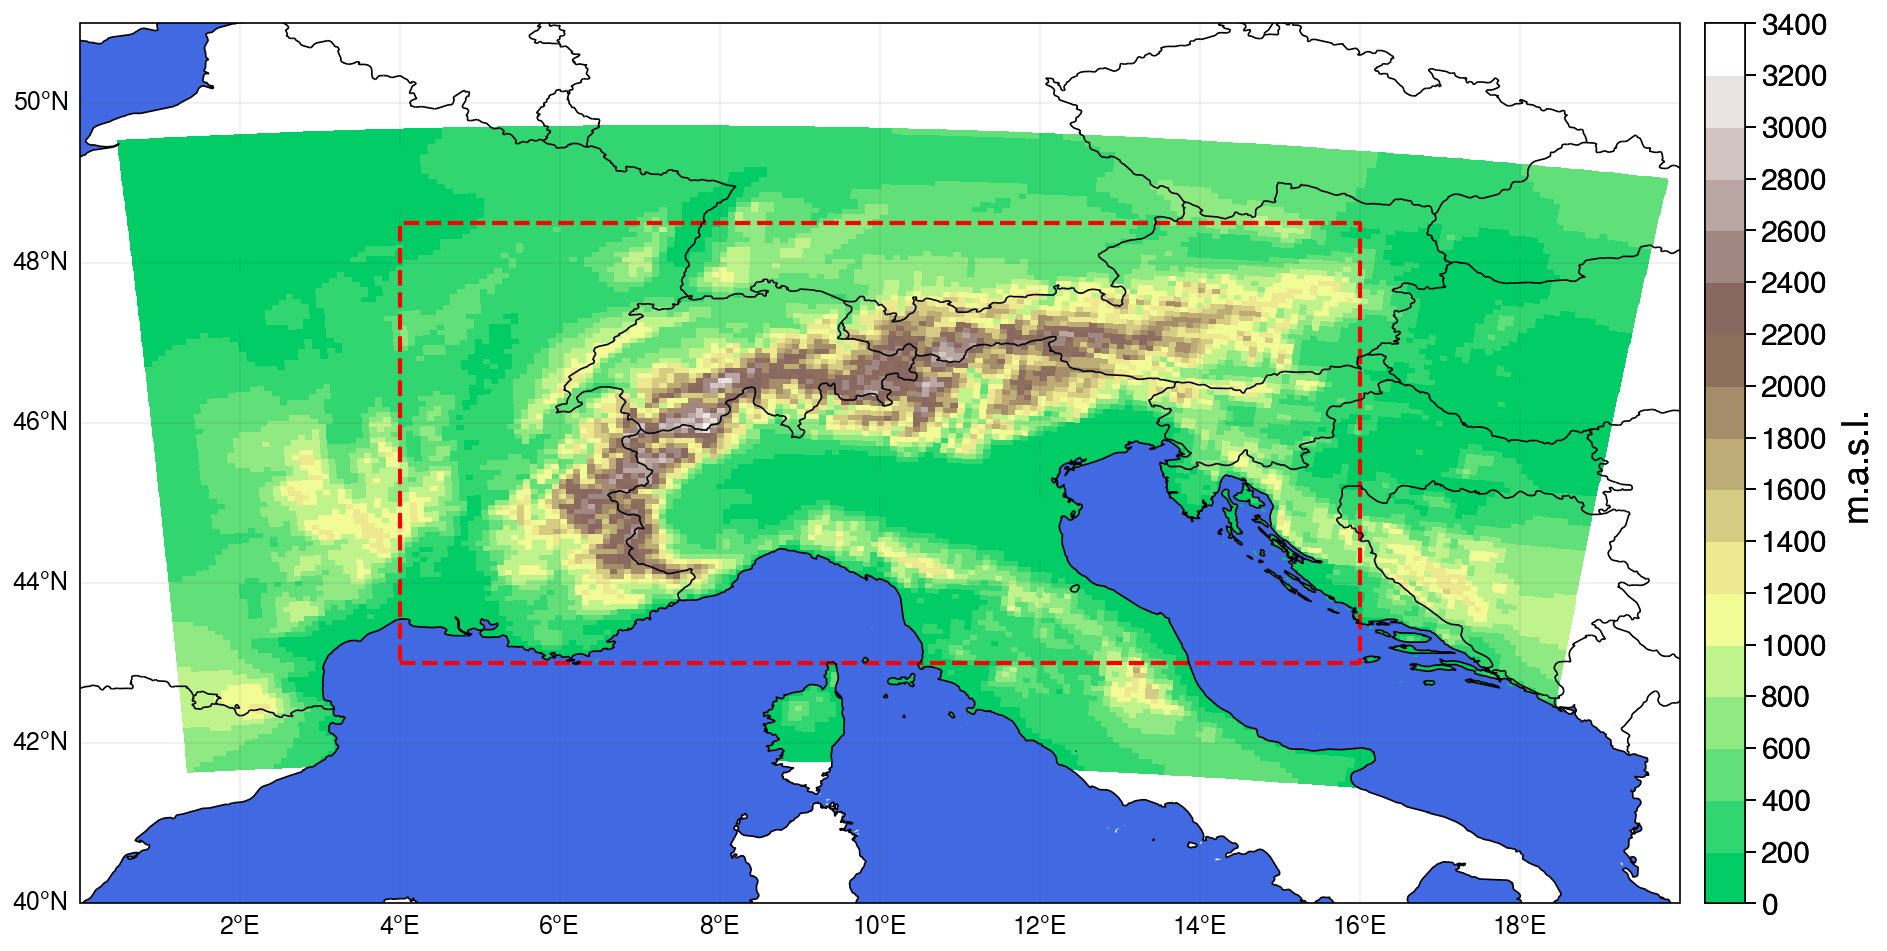

In [14]:
pplt.rc['figure.facecolor'] = 'white'

colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH, levels=17,cmap=colors_land)
f.colorbar(m,label= 'm.a.s.l.',labelsize='x-large',ticklabelsize='large')

ax.format(**normal_format)
ax.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])
ax.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')

### Compare climatology 1985-2014 to 2071-2100

In [5]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

In [37]:
first_year = 1985
last_year = 2014
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    seasonal_max_year=(ds_Tmax.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    if year> first_year:
        seasonal_mean_2014 += seasonal_mean_year
        seasonal_max_2014 += seasonal_max_year
    else:
        seasonal_mean_2014 = xr.DataArray.copy(seasonal_mean_year)
        seasonal_max_2014 = xr.DataArray.copy(seasonal_max_year)
seasonal_mean_2014 /= (last_year-first_year+1)
seasonal_max_2014 /= (last_year-first_year+1)

print(seasonal_mean_2014.shape, seasonal_mean_2014.season.data)

1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


In [21]:
first_year = 2071
last_year = 2100
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTmax.'+str(year)+'.nc')
    seasonal_max_year=(ds_Tmax.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    
    if year> first_year:
        seasonal_mean_2100 += seasonal_mean_year
        seasonal_max_2100 += seasonal_max_year
    else:
        seasonal_mean_2100 = xr.DataArray.copy(seasonal_mean_year)
        seasonal_max_2100 = xr.DataArray.copy(seasonal_max_year)
seasonal_mean_2100 /= (last_year-first_year+1)
seasonal_max_2100 /= (last_year-first_year+1)

print(seasonal_mean_2100.shape, seasonal_mean_2100.season.data)

2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


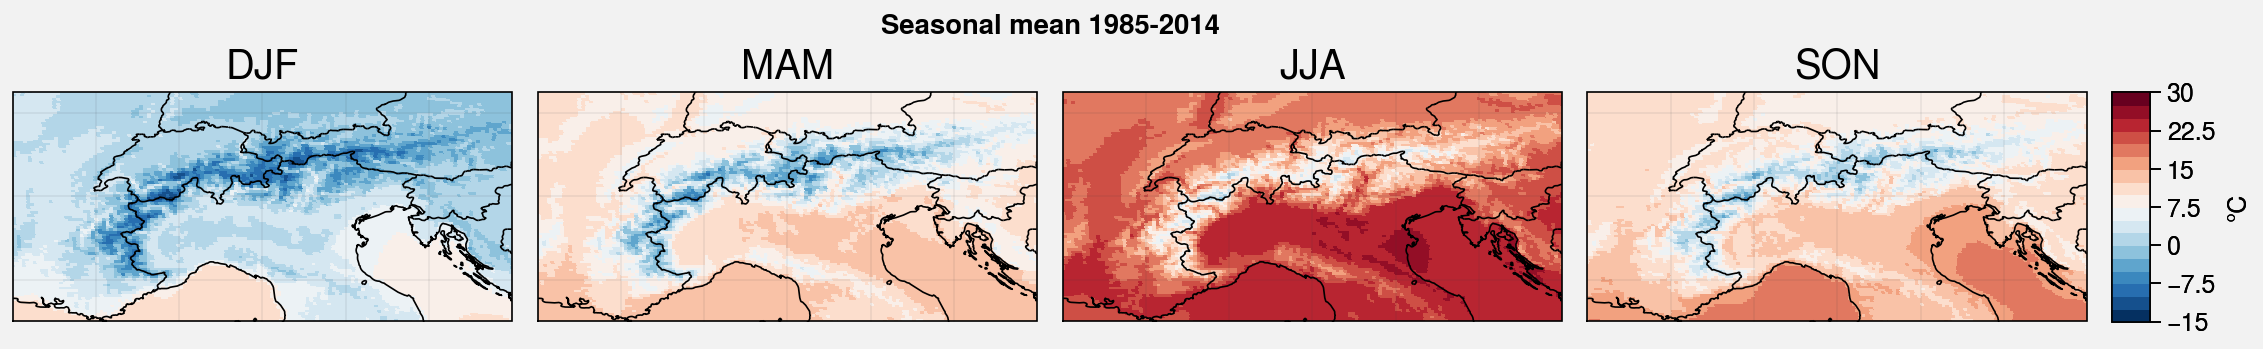

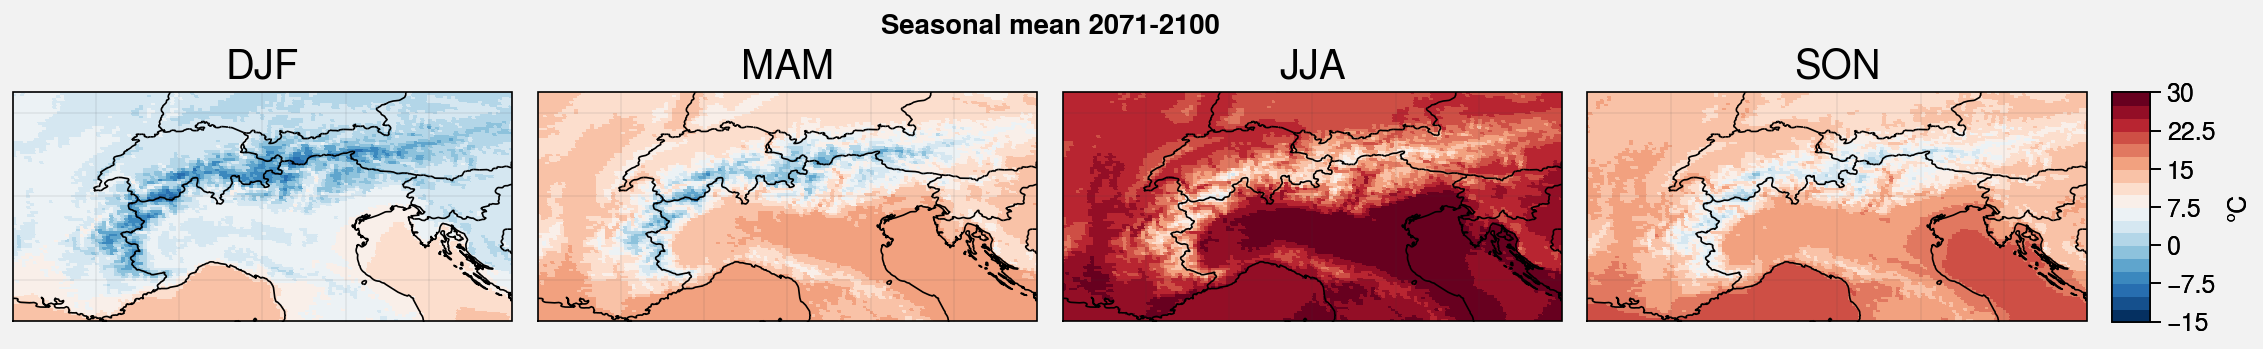

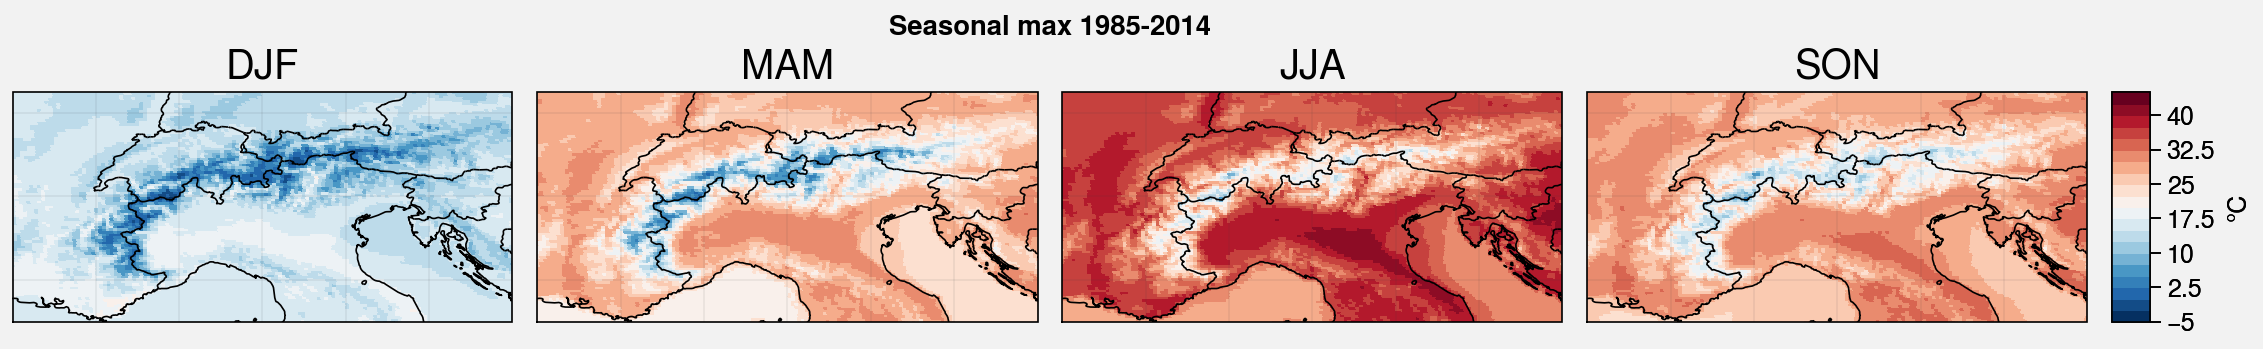

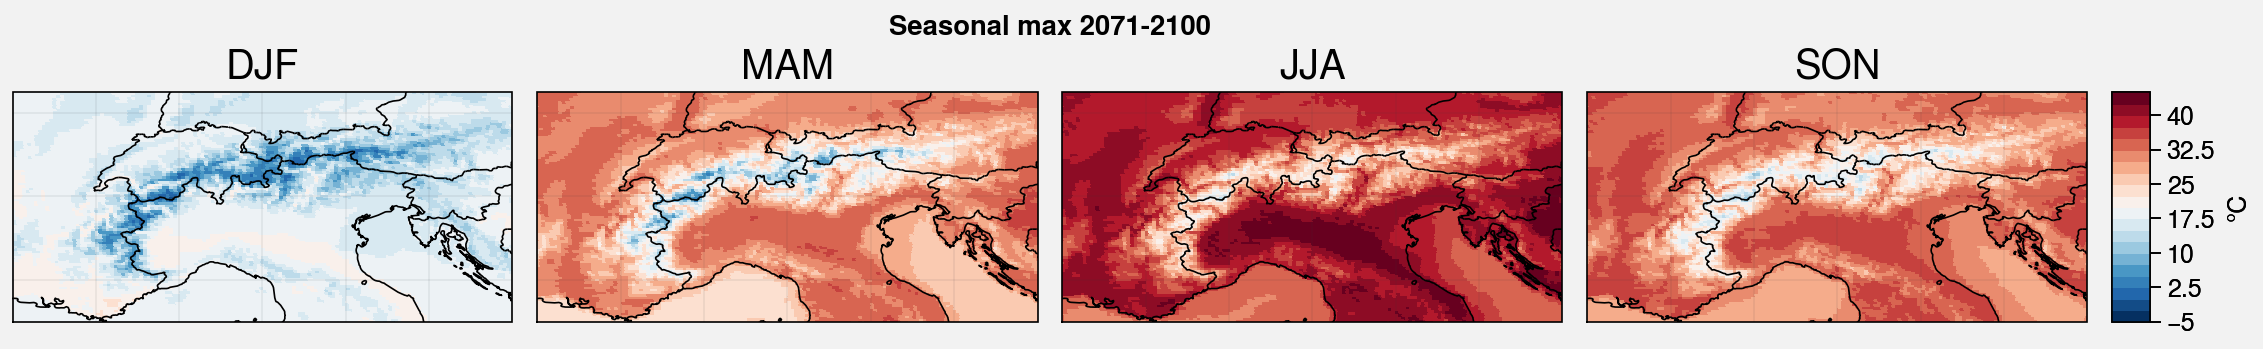

In [26]:
f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean[i,:,:],levels=np.linspace(-15,30,19),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean 1985-2014")


f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_mean_2100[i,:,:],levels=np.linspace(-15,30,19),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean 2071-2100")

f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_max[i,:,:],levels=np.linspace(-5,45,21),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal max 1985-2014")


f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(ds.LON,ds.LAT,seasonal_max_2100[i,:,:],levels=np.linspace(-5,45,21),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal max 2071-2100")

In [5]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool8(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_alps = np.copy(alps)
north_alps[lon>8.6] = False
north_alps[lat<45] = False
#north_alps[lat>46.5] = False

south_alps = np.copy(alps)
south_alps[lat>45] = False

east_alps = np.copy(alps)
east_alps[lon<8.6] = False

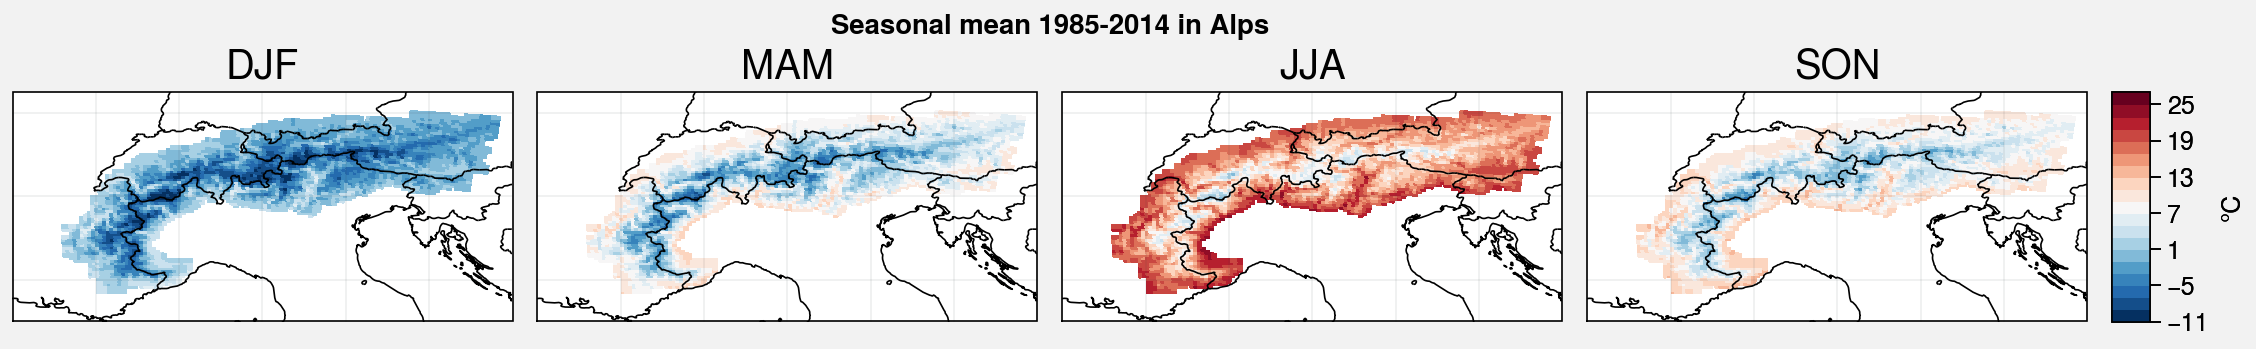

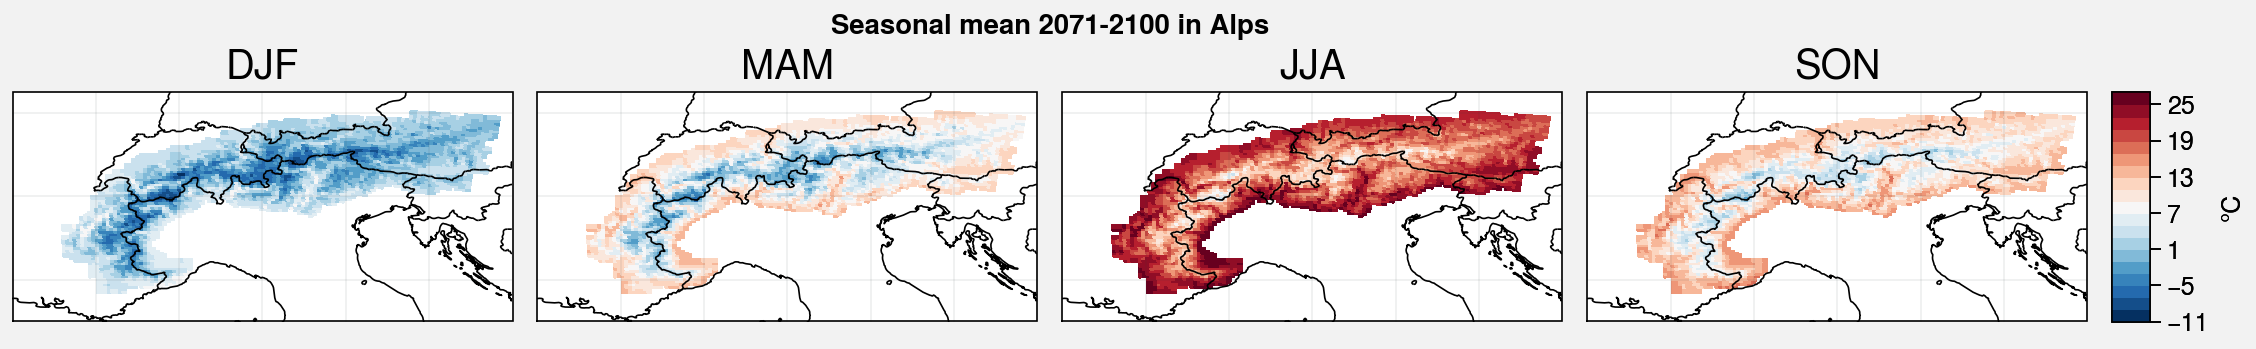

In [44]:
f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(lon,lat,np.ma.masked_array(seasonal_mean_2014[i,jmin:jmax,imin:imax],mask=np.invert(alps)),
                      levels=np.linspace(-11,27,20),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean 1985-2014 in Alps")


f, axs = pplt.subplots(proj='cyl',ncols=4)
for i, ax in enumerate(axs):
    m = ax.pcolormesh(lon,lat,np.ma.masked_array(seasonal_mean_2100[i,jmin:jmax,imin:imax],mask=np.invert(alps)),
                      levels=np.linspace(-11,27,20),cmap='RdBu_r')
    ax.format(title=['DJF','MAM','JJA', 'SON'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean 2071-2100 in Alps")

In [6]:
first_year = 1961
last_year = 1990
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    seasonal_max_year=(ds_Tmax.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    if year> first_year:
        seasonal_mean_1990 += seasonal_mean_year
        seasonal_max_1990 += seasonal_max_year
    else:
        seasonal_mean_1990 = xr.DataArray.copy(seasonal_mean_year)
        seasonal_max_1990 = xr.DataArray.copy(seasonal_max_year)
seasonal_mean_1990 /= (last_year-first_year+1)
seasonal_max_1990 /= (last_year-first_year+1)

print(seasonal_mean_1990.shape, seasonal_mean_1990.season.data)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


In [22]:
first_year = 1991
last_year = 2020
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
        ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    else:
        ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
        ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTmax.'+str(year)+'.nc')
    
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    seasonal_max_year=(ds_Tmax.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],
                                                                                                                dims=['season']))
    
    if year> first_year:
        seasonal_mean_2020 += seasonal_mean_year
        seasonal_max_2020 += seasonal_max_year
    else:
        seasonal_mean_2020 = xr.DataArray.copy(seasonal_mean_year)
        seasonal_max_2020 = xr.DataArray.copy(seasonal_max_year)
seasonal_mean_2020 /= (last_year-first_year+1)
seasonal_max_2020 /= (last_year-first_year+1)

print(seasonal_mean_2020.shape, seasonal_mean_2020.season.data)

1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


In [23]:
first_year = 2021
last_year = 2050
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
    seasonal_mean_year=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    ds_Tmax = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTmax.'+str(year)+'.nc')
    seasonal_max_year=(ds_Tmax.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],
                                                                                                                dims=['season']))
    
    if year> first_year:
        seasonal_mean_2050 += seasonal_mean_year
        seasonal_max_2050 += seasonal_max_year
    else:
        seasonal_mean_2050 = xr.DataArray.copy(seasonal_mean_year)
        seasonal_max_2050 = xr.DataArray.copy(seasonal_max_year)
seasonal_mean_2050 /= (last_year-first_year+1)
seasonal_max_2050 /= (last_year-first_year+1)

print(seasonal_mean_2050.shape, seasonal_mean_2050.season.data)

2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 (4, 126, 201) ['DJF' 'MAM' 'JJA' 'SON']


In [24]:
seasonal_means = [seasonal_mean_1990,seasonal_mean_2020,seasonal_mean_2050,seasonal_mean_2100]

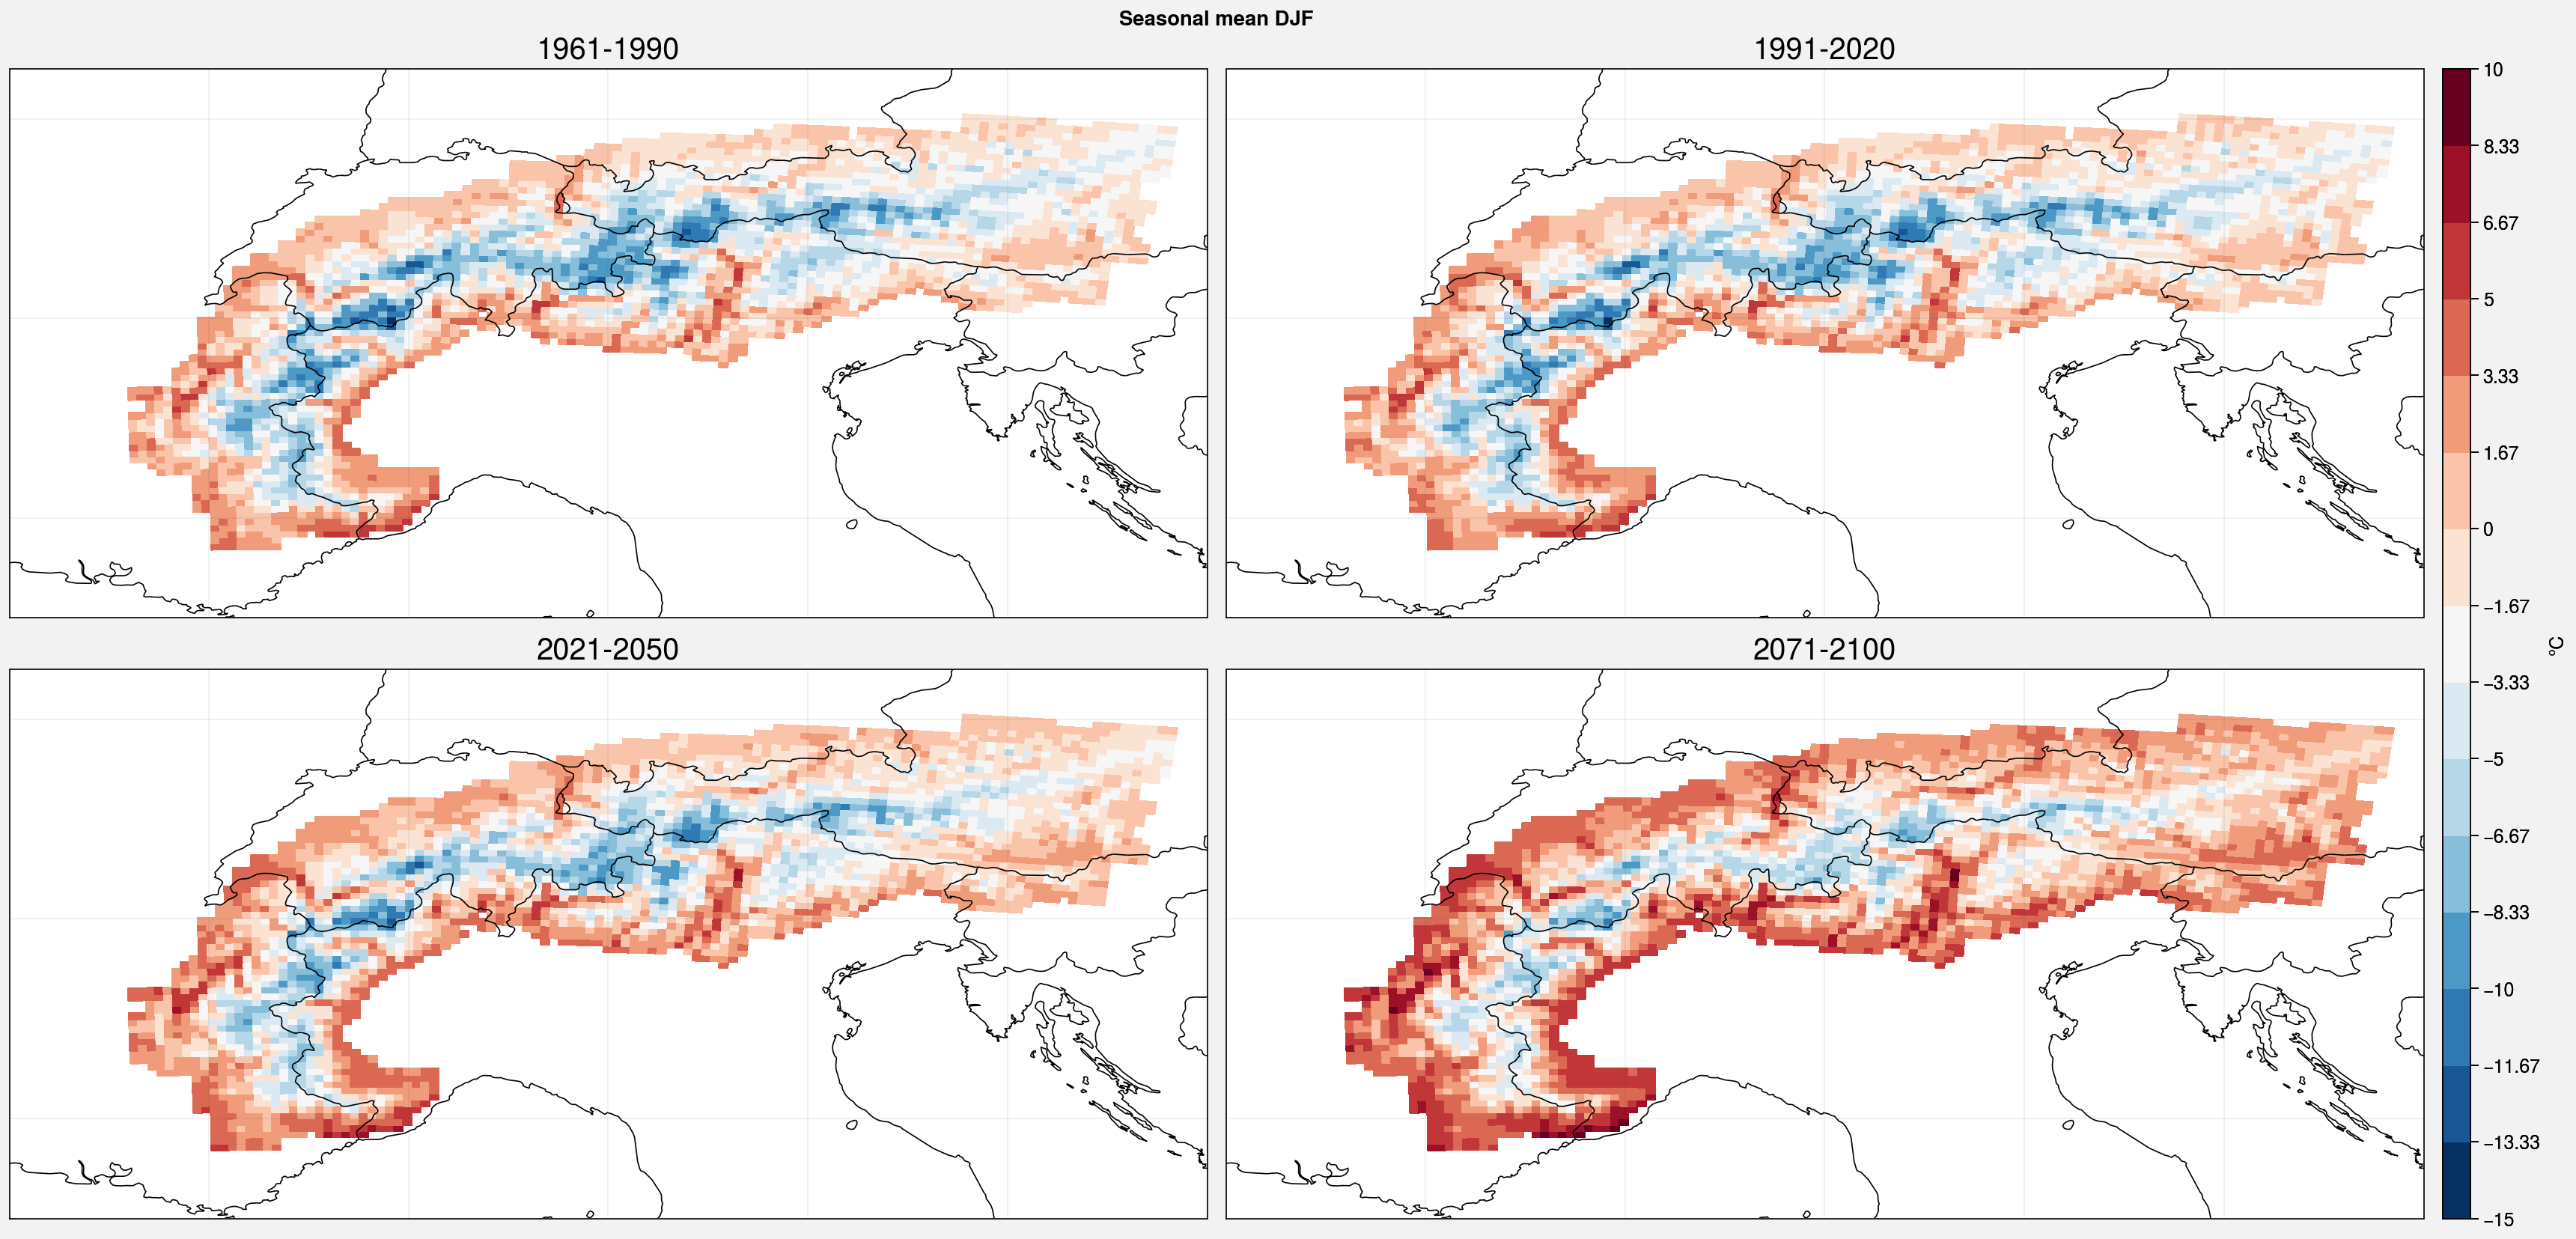

In [27]:
f, axs = pplt.subplots(proj='cyl',axwidth=8,ncols=2,nrows=2)
seas = 0

for i, ax in enumerate(axs):
    m = ax.pcolormesh(lon,lat,np.ma.masked_array(seasonal_means[i][seas,jmin:jmax,imin:imax],mask=np.invert(alps)),
                      levels=np.linspace(-15,10,16),cmap='RdBu_r')
    ax.format(title=['1961-1990','1991-2020','2021-2050', '2071-2100'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean DJF")

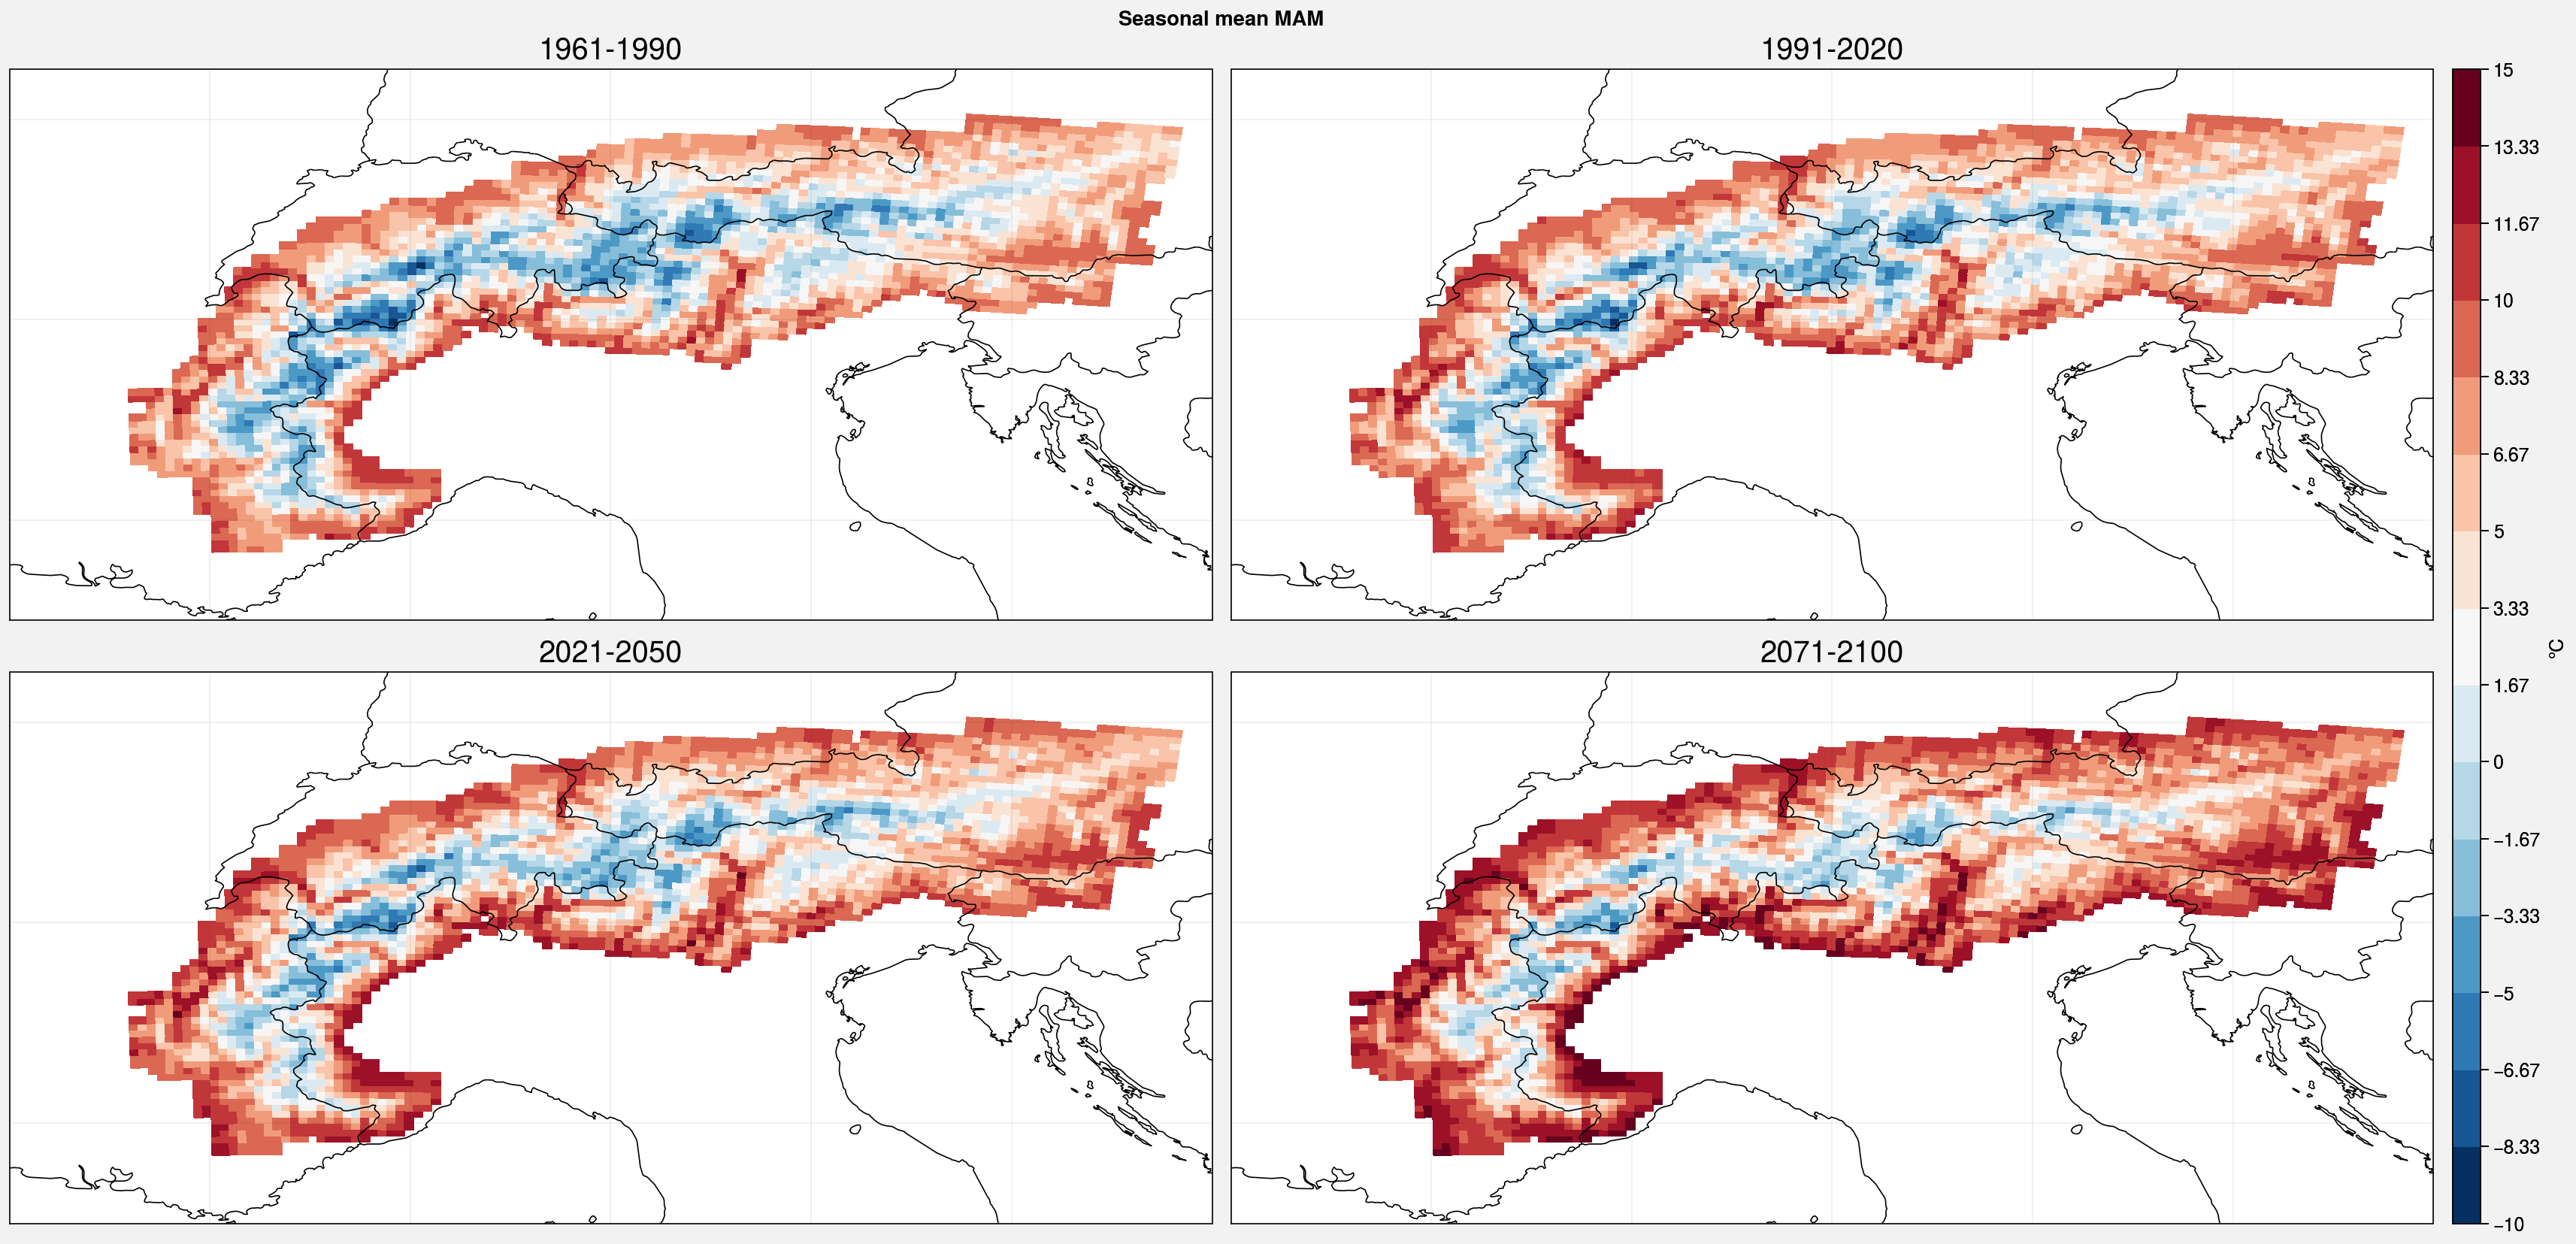

In [29]:
f, axs = pplt.subplots(proj='cyl',axwidth=8,ncols=2,nrows=2)
seas = 1

for i, ax in enumerate(axs):
    m = ax.pcolormesh(lon,lat,np.ma.masked_array(seasonal_means[i][seas,jmin:jmax,imin:imax],mask=np.invert(alps)),
                      levels=np.linspace(-10,15,16),cmap='RdBu_r')
    ax.format(title=['1961-1990','1991-2020','2021-2050', '2071-2100'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean MAM")

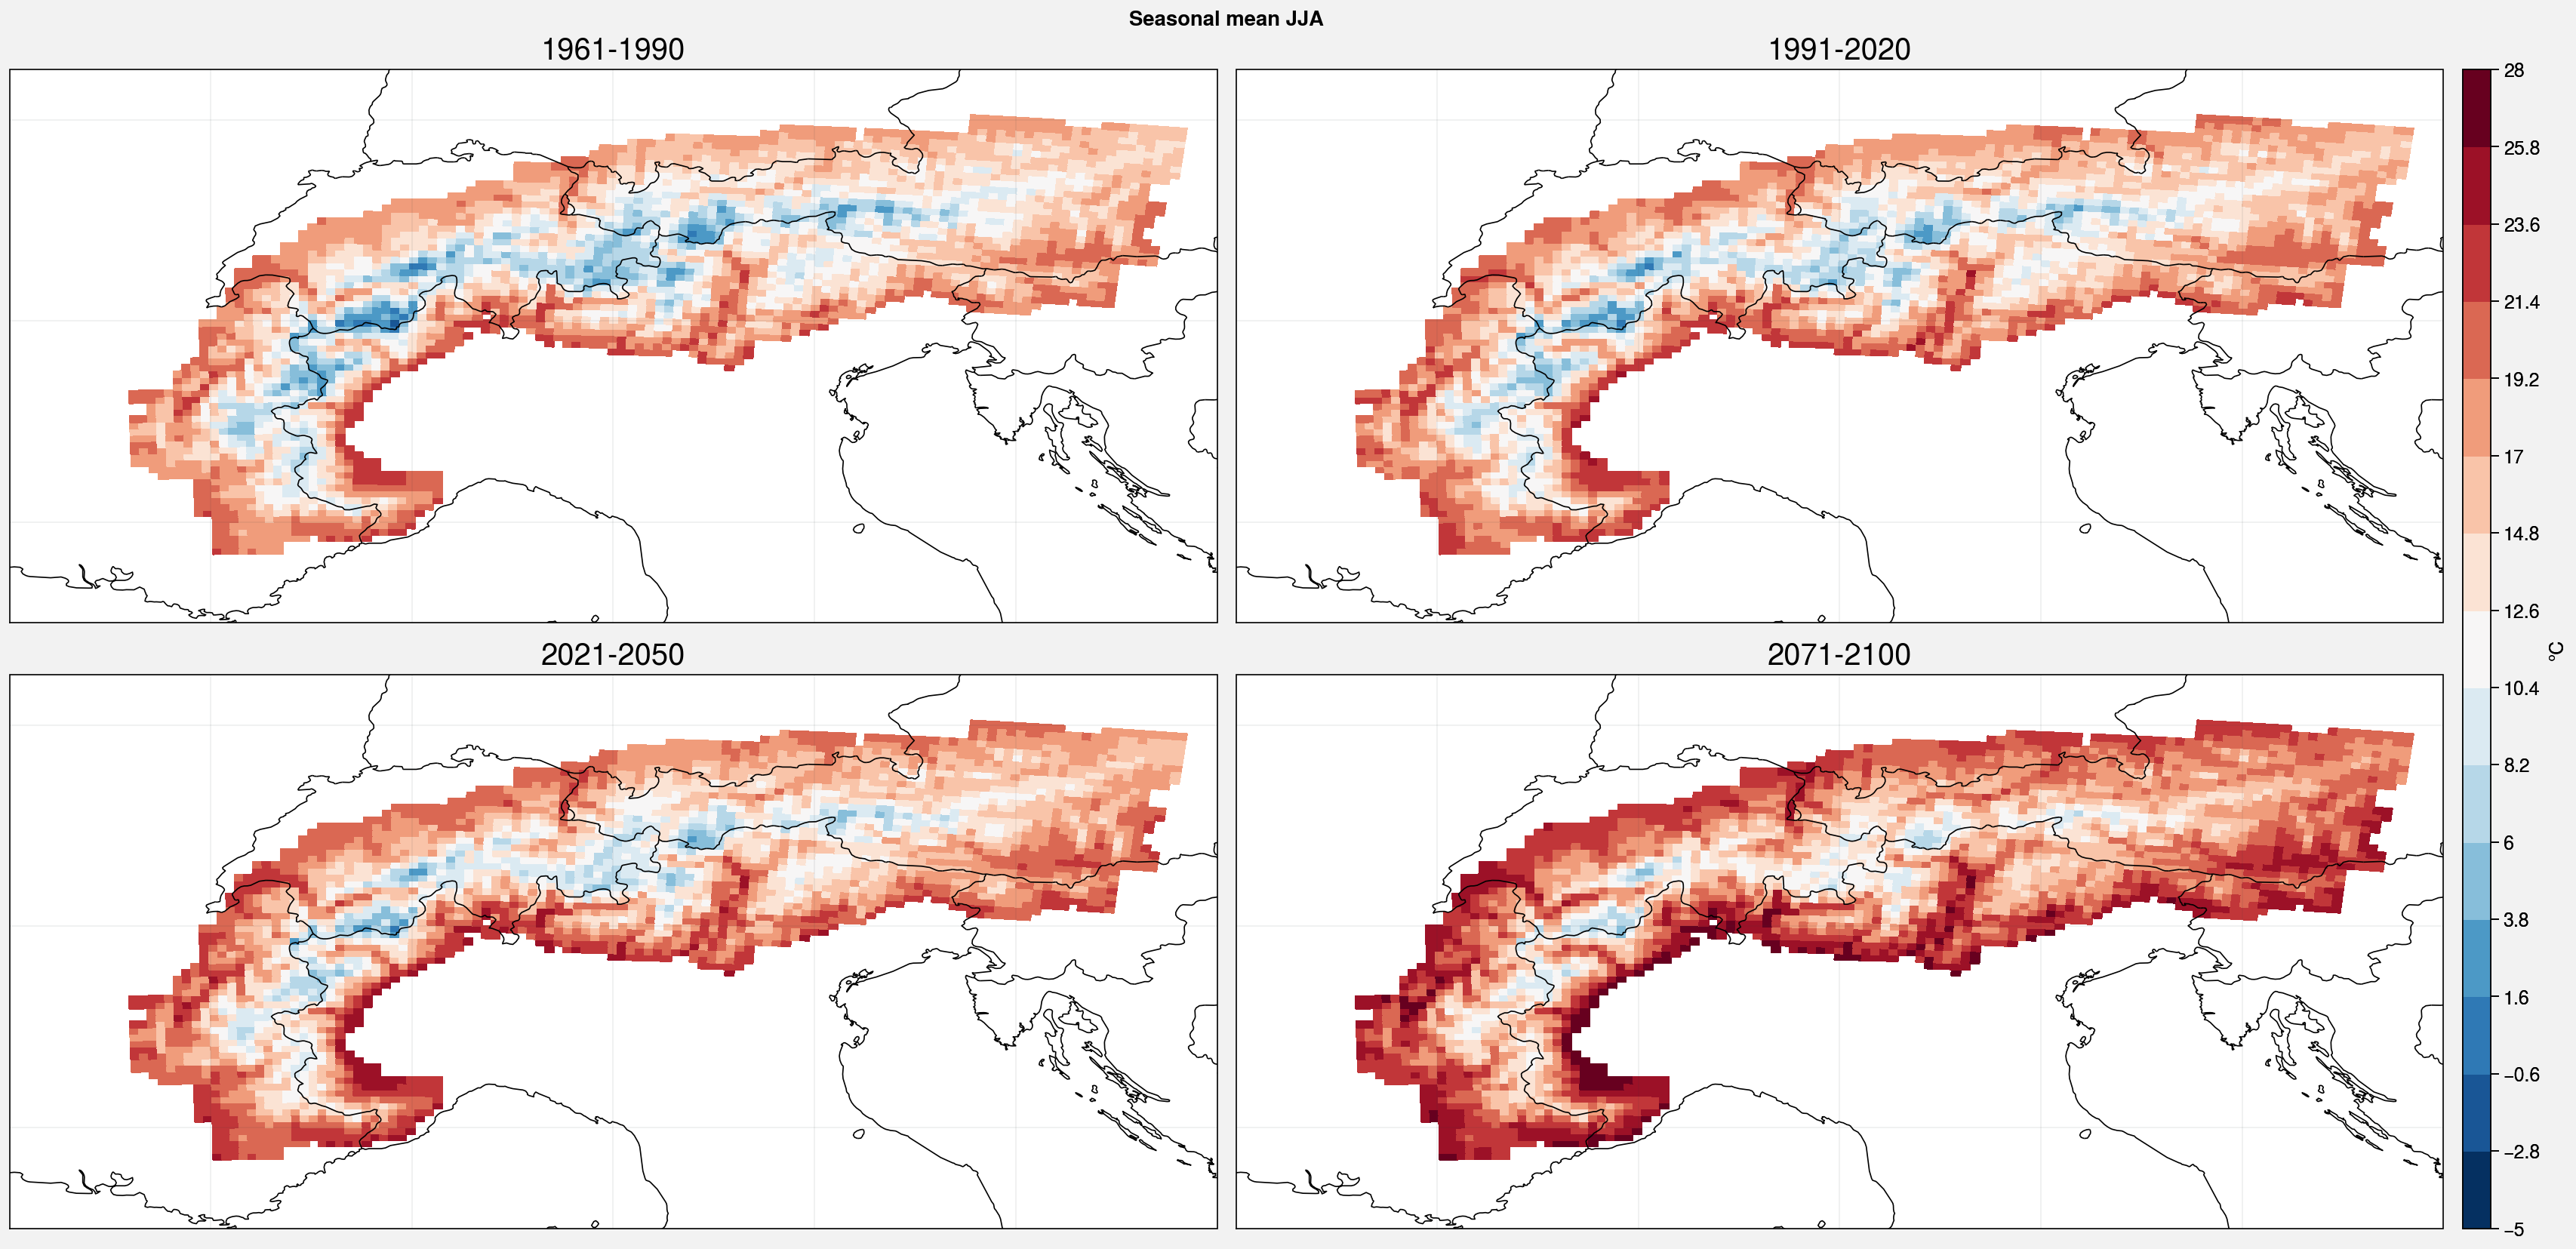

In [33]:
f, axs = pplt.subplots(proj='cyl',axwidth=8,ncols=2,nrows=2)
seas = 2

for i, ax in enumerate(axs):
    m = ax.pcolormesh(lon,lat,np.ma.masked_array(seasonal_means[i][seas,jmin:jmax,imin:imax],mask=np.invert(alps)),
                      levels=np.linspace(-5,28,16),cmap='RdBu_r')
    ax.format(title=['1961-1990','1991-2020','2021-2050', '2071-2100'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean JJA")

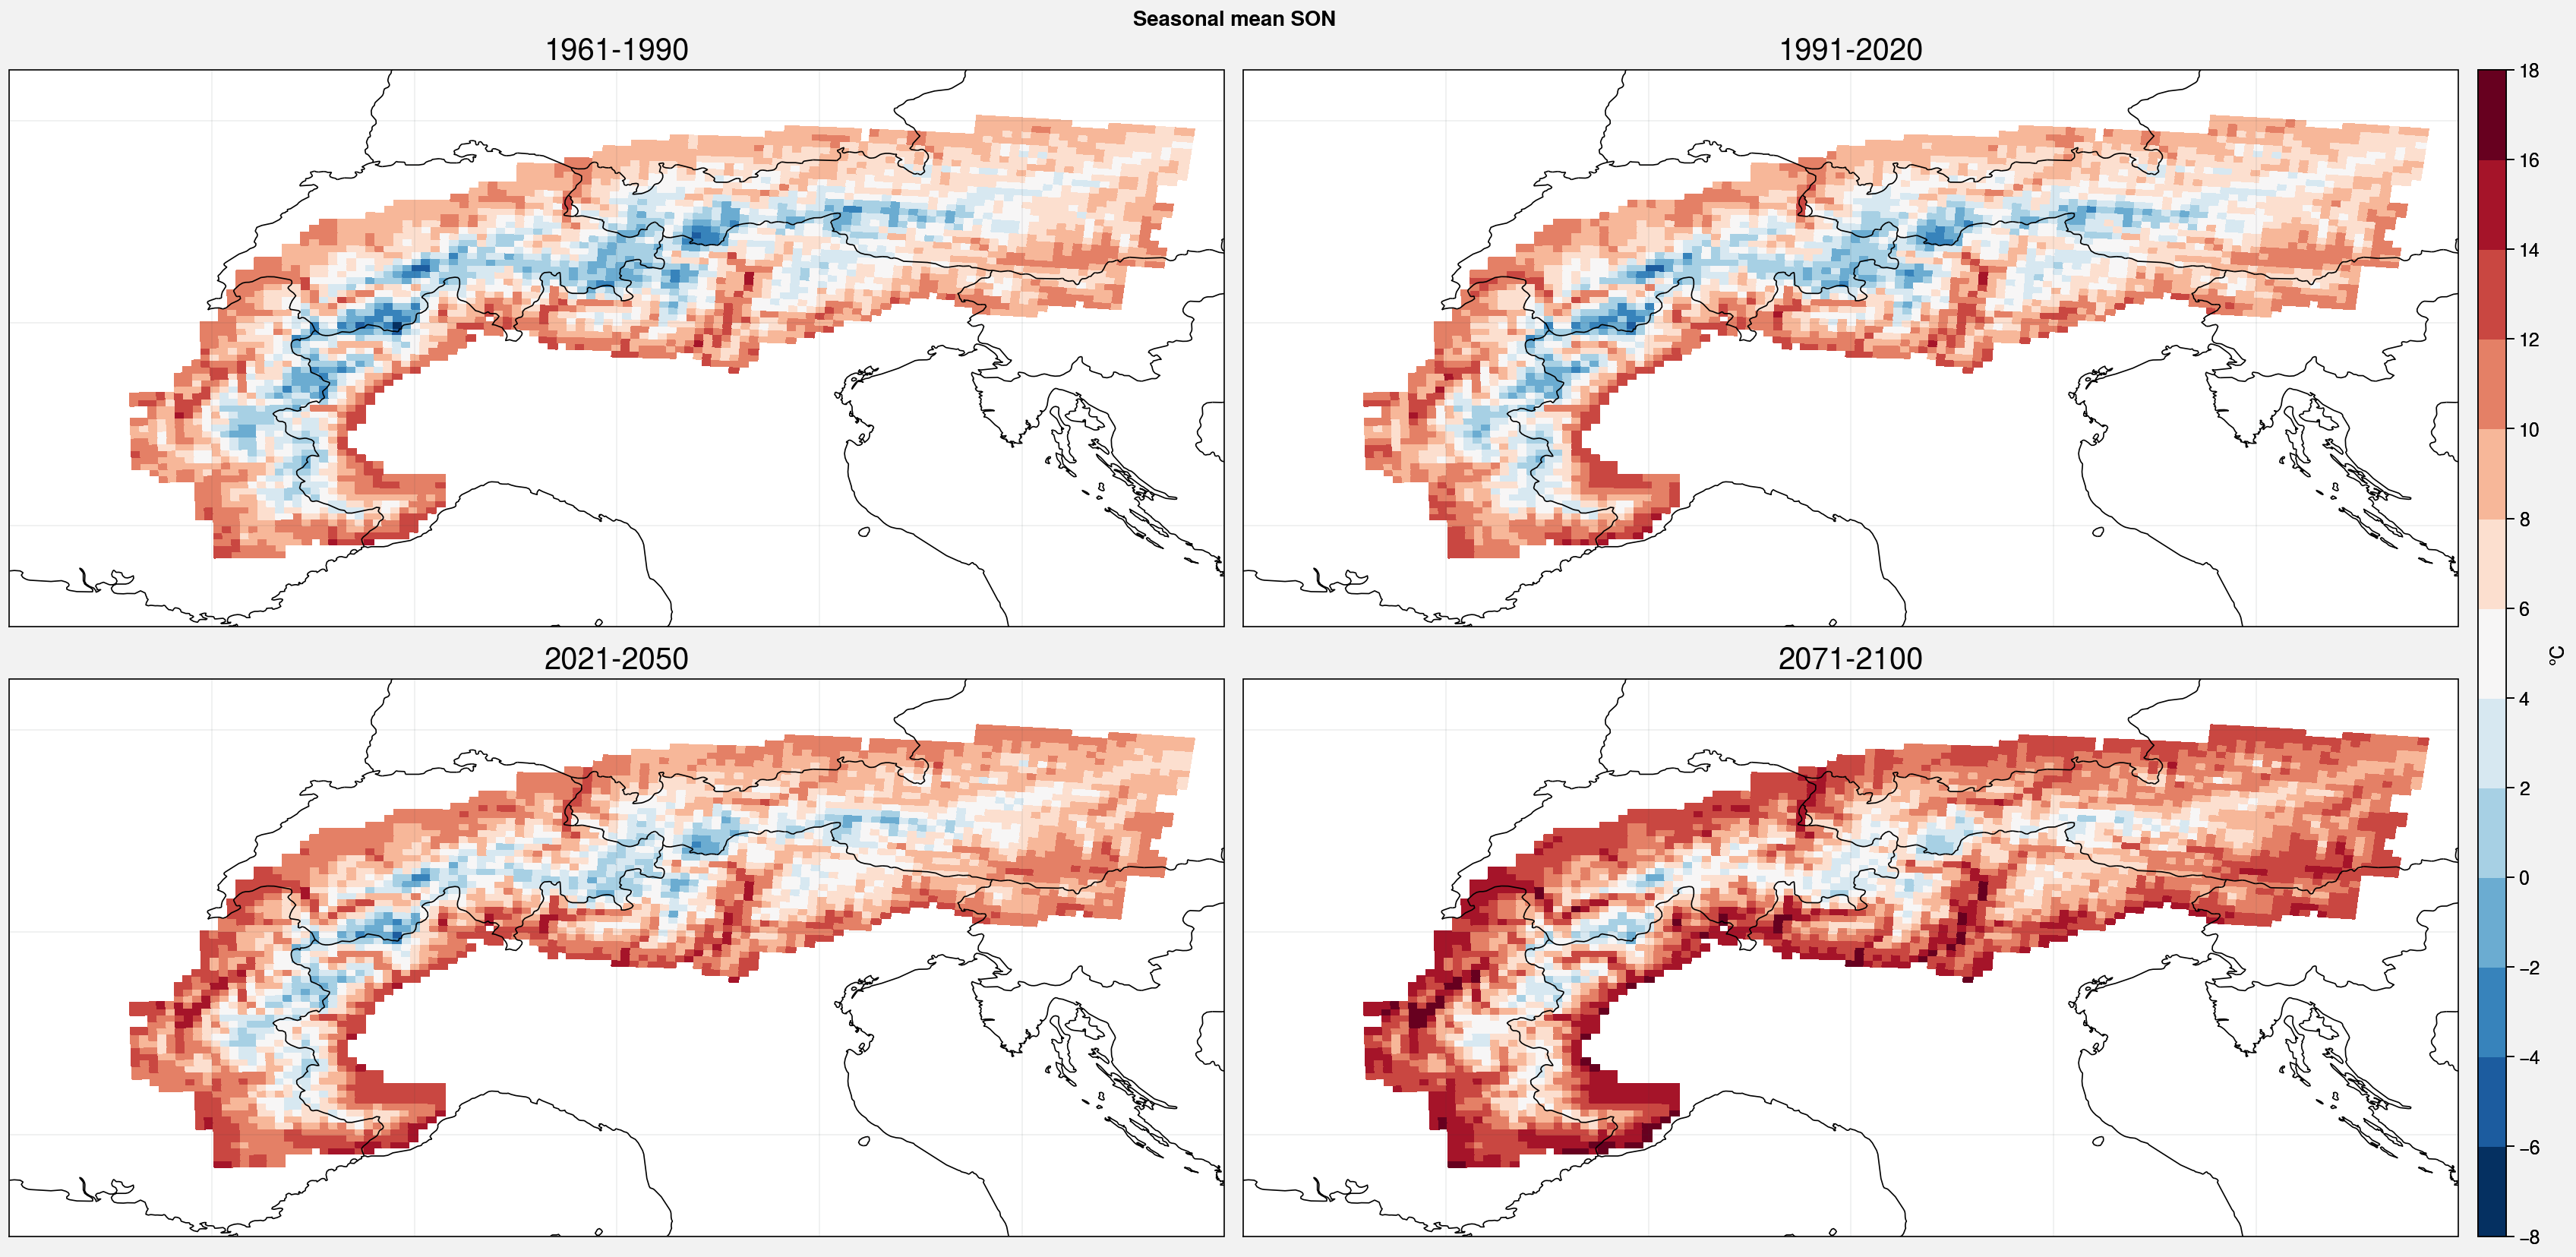

In [36]:
f, axs = pplt.subplots(proj='cyl',axwidth=8,ncols=2,nrows=2)
seas = 3

for i, ax in enumerate(axs):
    m = ax.pcolormesh(lon,lat,np.ma.masked_array(seasonal_means[i][seas,jmin:jmax,imin:imax],mask=np.invert(alps)),
                      levels=np.linspace(-8,18,14),cmap='RdBu_r')
    ax.format(title=['1961-1990','1991-2020','2021-2050', '2071-2100'][i],titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Seasonal mean SON")

### Save data for 1961-2100

In [ ]:
name_GCM = 'EC-Earth3'
scenario = 'SSP245'
sim = 'EUe'

data_freq = 'monthly'
data_freq_prefix = 'MON' # ICE for daily, MON for monthly

first_year = 1961
last_year = 2100

#### Temperature

In [9]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_meanT = np.zeros(((last_year-first_year+1),4,126,201))
wp_maxseason_maxT = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
        ds_max = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
        ds_max = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTmax.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_mean.TTz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanT[year-first_year] = season_mean_year
    season_max_year=(ds_max.TTmax.isel(atmlay=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_maxseason_maxT[year-first_year] = season_max_year

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [10]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy', wp_meanseason_meanT)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_maxseason_maxT.npy', wp_maxseason_maxT)

In [8]:
ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.2000.nc')
ds_mean.TTz.isel(ztqlev=2)

<xarray.DataArray 'TTz' (time: 366, y: 126, x: 201)>
[9269316 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
    ztqlev   float32 50.0
Attributes:
    units:          C
    long_name:      Temperature
    standard_name:  Temperature
    actual_range:   [-20.328133  15.521057]

In [10]:
first_year = 1961
last_year = 2100
wp_meanseason_meanT_50m = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanT_100m = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_mean.TTz.isel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanT_50m[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.TTz.isel(ztqlev=3)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanT_100m[year-first_year] = season_mean_year

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [11]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT_50m.npy', wp_meanseason_meanT_50m)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT_100m.npy', wp_meanseason_meanT_100m)

#### Temperature by pressure levels

In [7]:

ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTp.2000.nc')

ds_mean.plev


<xarray.DataArray 'plev' (plev: 7)>
array([925., 850., 800., 700., 600., 500., 200.], dtype=float32)
Coordinates:
  * plev     (plev) float32 925.0 850.0 800.0 700.0 600.0 500.0 200.0
Attributes:
    units:          hPa
    long_name:      plev
    standard_name:  plev

In [8]:
first_year = 1961
last_year = 2100

wp_meanseason_meanTTp_925 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_850 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_800 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_700 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_600 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_500 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_200 = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTp.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTp.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_mean.TTp.sel(plev=925)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_925[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.TTp.sel(plev=850)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_850[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.TTp.sel(plev=800)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_800[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.TTp.sel(plev=700)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_700[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.TTp.sel(plev=600)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_600[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.TTp.sel(plev=500)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_500[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.TTp.sel(plev=200)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_200[year-first_year] = season_mean_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [9]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_925.npy', wp_meanseason_meanTTp_925)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_850.npy', wp_meanseason_meanTTp_850)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_800.npy', wp_meanseason_meanTTp_800)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_700.npy', wp_meanseason_meanTTp_700)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_600.npy', wp_meanseason_meanTTp_600)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_500.npy', wp_meanseason_meanTTp_500)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanTTp_200.npy', wp_meanseason_meanTTp_200)

#### Surface Pressure

In [28]:
first_year = 1961
last_year = 2100
wp_meanseason_meanSP = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.SP.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.SP.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_mean.SP).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanSP[year-first_year] = season_mean_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [29]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanSP.npy', wp_meanseason_meanSP)

#### Shortwave radiation

In [19]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_meanSWD = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanSWU = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_SWD = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.SWD.'+str(year)+'.nc')
        ds_SWU = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.SWU.'+str(year)+'.nc')
    elif year==2063:
        ds_SWD = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.SWD.2062.nc')
        ds_SWU = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.SWU.2062.nc')
    else:
        ds_SWD = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.SWD.'+str(year)+'.nc')
        ds_SWU = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.SWU.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_SWD.SWD).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanSWD[year-first_year] = season_mean_year
    season_mean_year=season_mean(ds_SWU.SWU).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanSWU[year-first_year] = season_mean_year

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [21]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanSWD.npy', wp_meanseason_meanSWD)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanSWU.npy', wp_meanseason_meanSWU)

#### Specific Humidity

In [7]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_meanQQz = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_QQz = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.QQz.'+str(year)+'.nc')
    else:
        ds_QQz = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.QQz.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_QQz.QQz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQz[year-first_year] = season_mean_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [8]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQz.npy', wp_meanseason_meanQQz)

#### Specific Humidity at pressure levels

In [4]:
first_year = 1961
last_year = 2100

wp_meanseason_meanQQp_925 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanQQp_850 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanQQp_800 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanQQp_700 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanQQp_600 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanQQp_500 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanQQp_200 = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/HIST/ICE.EC-Earth3_HIST.EUe.QQp.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/SSP245/ICE.EC-Earth3_SSP245.EUe.QQp.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_mean.QQp.sel(plev=925)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQp_925[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.QQp.sel(plev=850)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQp_850[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.QQp.sel(plev=800)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQp_800[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.QQp.sel(plev=700)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQp_700[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.QQp.sel(plev=600)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQp_600[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.QQp.sel(plev=500)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQp_500[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_mean.QQp.sel(plev=200)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQp_200[year-first_year] = season_mean_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [5]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQp_925.npy', wp_meanseason_meanQQp_925)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQp_850.npy', wp_meanseason_meanQQp_850)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQp_800.npy', wp_meanseason_meanQQp_800)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQp_700.npy', wp_meanseason_meanQQp_700)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQp_600.npy', wp_meanseason_meanQQp_600)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQp_500.npy', wp_meanseason_meanQQp_500)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanQQp_200.npy', wp_meanseason_meanQQp_200)

#### Min T and max T

In [9]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_minT = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_maxT = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year ==1982:
        ds_min = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/HIST/ICE.EC-Earth3_HIST.EUe.TTmin.1982.nc')
        ds_max = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    elif year <2015:
        ds_min = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmin.'+str(year)+'.nc')
        ds_max = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    else:
        ds_min = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTmin.'+str(year)+'.nc')
        ds_max = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTmax.'+str(year)+'.nc')
    season_minT_year=season_mean(ds_min.TTmin.isel(atmlay=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_minT[year-first_year] = season_minT_year
    season_maxT_year=season_mean(ds_max.TTmax.isel(atmlay=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_maxT[year-first_year] = season_maxT_year

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [10]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_minT.npy', wp_meanseason_minT)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_maxT.npy', wp_meanseason_maxT)

#### Albedo

In [12]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_AL = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year ==2029:
        ds_AL = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/SSP245/ICE.EC-Earth3_SSP245.EUe.AL.2029.nc')
    elif year <2015:
        ds_AL = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.AL.'+str(year)+'.nc')
    else:
        ds_AL = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.AL.'+str(year)+'.nc')
    season_AL_year=season_mean(ds_AL.AL).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_AL[year-first_year] = season_AL_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [13]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_AL.npy', wp_meanseason_AL)

#### Long Wave Down and Up

In [8]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_LWD = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_LWD = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.LWD.'+str(year)+'.nc')
    else:
        ds_LWD = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.LWD.'+str(year)+'.nc')
    season_LWD_year=season_mean(ds_LWD.LWD).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_LWD[year-first_year] = season_LWD_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [9]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_LWD.npy', wp_meanseason_LWD)

In [9]:
first_year = 1961
last_year = 2100
wp_meanseason_LWU = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_LWU = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.LWU.'+str(year)+'.nc')
    else:
        ds_LWU = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.LWU.'+str(year)+'.nc')
    season_LWU_year=season_mean(ds_LWU.LWU).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_LWU[year-first_year] = season_LWU_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [10]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_LWU.npy', wp_meanseason_LWU)

#### Temperature yearly max

In [4]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_maxseason_meanT = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')

    season_max_year=(ds_mean.TTz.isel(ztqlev=0)).groupby("time.season").max(dim="time").sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_maxseason_meanT[year-first_year] = season_max_year

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [5]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_maxseason_meanT.npy', wp_maxseason_meanT)

#### Latent and Sensible heat fluxes (LHF and SHF)

In [6]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_LHF = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_SHF = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    #if year ==1982:
   #     ds_min = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/HIST/ICE.EC-Earth3_HIST.EUe.TTmin.1982.nc')
   #     ds_max = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTmax.'+str(year)+'.nc')
    if year <2015:
        ds_LHF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.LHF.'+str(year)+'.nc')
        ds_SHF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.SHF.'+str(year)+'.nc')
    else:
        ds_LHF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.LHF.'+str(year)+'.nc')
        ds_SHF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.SHF.'+str(year)+'.nc')
    season_LHF_year=season_mean(ds_LHF.LHF).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_LHF[year-first_year] = season_LHF_year
    season_SHF_year=season_mean(ds_SHF.SHF).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_SHF[year-first_year] = season_SHF_year

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [7]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_LHF.npy', wp_meanseason_LHF)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_SHF.npy', wp_meanseason_SHF)

#### verification sign LHF and SHF

In [3]:
year = 2000

ds_LHF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.LHF.'+str(year)+'.nc')
ds_SHF = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.SHF.'+str(year)+'.nc')

ds_ST = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.ST.'+str(year)+'.nc')
ds_TT = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TT.'+str(year)+'.nc')
ds_TTz = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.TTz.'+str(year)+'.nc')

In [10]:
ds_TT.TT.isel(atmlay=0)

<xarray.DataArray 'TT' (time: 366, y: 126, x: 201)>
[9269316 values with dtype=float32]
Coordinates:
    atmlay   float32 0.9997
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
Attributes:
    units:          C
    long_name:      Temperature
    standard_name:  Temperature
    actual_range:   [-20.345448  14.47918 ]

In [39]:
np.array(ds_ST.ST[:,50,0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

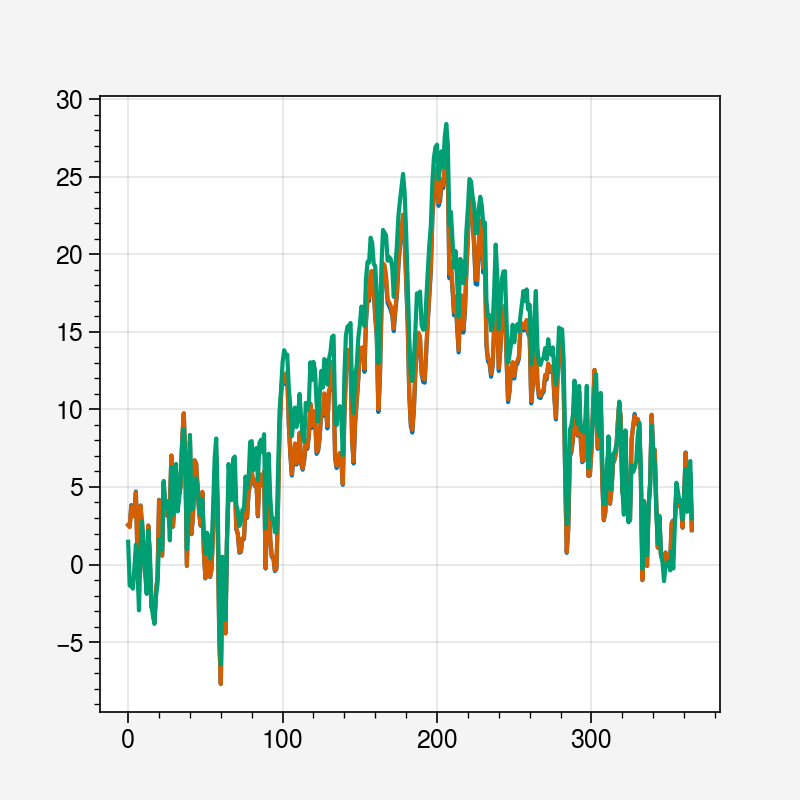

In [40]:
x=10
y=10

plt.plot(ds_TT.TT.isel(atmlay=0)[:,x,y])
plt.plot(ds_TTz.TTz.isel(ztqlev=0)[:,x,y])
plt.plot(ds_ST.ST[:,x,y])

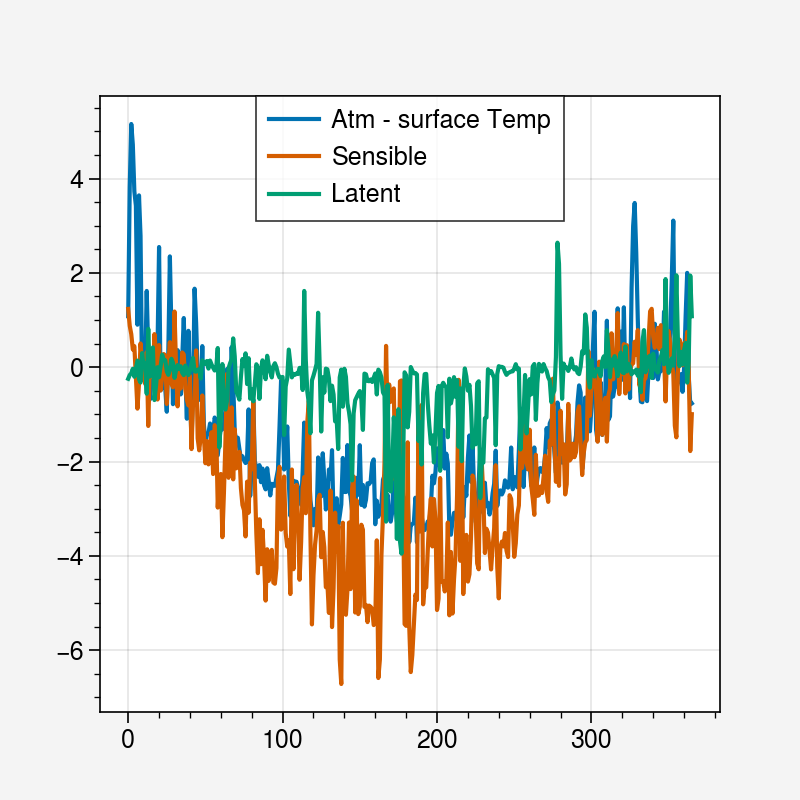

In [43]:
plt.plot(ds_TT.TT.isel(atmlay=0)[:,x,y]-ds_ST.ST[:,x,y],label='Atm - surface Temp')
plt.plot(ds_SHF.SHF[:,x,y]/20,label='Sensible')
plt.plot(ds_LHF.LHF[:,x,y]/20,label='Latent')

plt.legend()

#### Surface temperature

In [4]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_ST = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.ST.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.ST.'+str(year)+'.nc')
    season_mean_year=season_mean(ds_mean.ST).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_ST[year-first_year] = season_mean_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [5]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_ST.npy', wp_meanseason_ST)

#### Cloud cover

In [12]:
# wp = whole period

first_year = 1961
last_year = 2100
wp_meanseason_CC = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_CD = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_CM = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_CU = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_CC = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.CC.'+str(year)+'.nc')
        ds_CD = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.CD.'+str(year)+'.nc')
        ds_CM = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.CM.'+str(year)+'.nc')
        ds_CU = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.CU.'+str(year)+'.nc')
    else:
        ds_CC = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.CC.'+str(year)+'.nc')
        ds_CD = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.CD.'+str(year)+'.nc')
        ds_CM = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.CM.'+str(year)+'.nc')
        ds_CU = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.CU.'+str(year)+'.nc')
    
    season_mean_year=season_mean(ds_CC.CC).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_CC[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_CD.CD).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_CD[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_CM.CM).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_CM[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_CU.CU).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_CU[year-first_year] = season_mean_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [13]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_CC.npy', wp_meanseason_CC)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_CD.npy', wp_meanseason_CD)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_CM.npy', wp_meanseason_CM)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_CU.npy', wp_meanseason_CU)

#### Melting

In [7]:
# wp = whole period

Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
t_day = 86400 # 60*60*24 seconds in a day

first_year = 1961
last_year = 2100
wp_meanseason_MBm = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meltenergy = np.zeros(((last_year-first_year+1),4,126,201))

ds_FRV = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/ICE.EC-Earth3.EUe.FRV.08.1975.nc')
FRV_sect1 = np.array(ds_FRV.FRV.sel(sector=1.0)/100)
FRV_sect2 = np.array(ds_FRV.FRV.sel(sector=2.0)/100)
FRV_sect3 = np.array(ds_FRV.FRV.sel(sector=3.0)/100)

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    if year <2015:
        ds_mean = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/HIST/ICE.EC-Earth3_HIST.EUe.MBm.'+str(year)+'.nc')
    else:
        ds_mean = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/SSP245/ICE.EC-Earth3_SSP245.EUe.MBm.'+str(year)+'.nc')
    
    melt_MBm_sect1 = ds_mean.MBm.sel(sector=1.0)
    melt_MBm_sect2 = ds_mean.MBm.sel(sector=2.0)
    melt_MBm_sect3 = ds_mean.MBm.sel(sector=3.0)
    melt_MBm = melt_MBm_sect1*FRV_sect1 + melt_MBm_sect2*FRV_sect2 + melt_MBm_sect3*FRV_sect3
    
    season_mean_year=season_mean(melt_MBm).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_MBm[year-first_year] = season_mean_year

    energy_melt_MBm = melt_MBm*Lf # kg.m**(-2) * J.kg**(-1) = J.m**(-2)
    flux_melt_MBm = energy_melt_MBm/t_day # in W.m**(-2)
    season_mean_year=season_mean(flux_melt_MBm).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meltenergy[year-first_year] = season_mean_year


1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [8]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_totMBm.npy', wp_meanseason_MBm)
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meltenergy.npy', wp_meanseason_meltenergy)

## MAR-MPI-ESM1-2-HR SSP245

### Save data for 1961-2100

In [6]:
name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'SSP245'
sim = 'EUy'
sim2 = 'EUv'

data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly

first_year = 1961
last_year = 2100

In [11]:
# TTz

Tmean_seas = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    #if year == 1985 or year == 2071:
    #    continue
    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.TTz.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.TTz.'+str(year)+'.nc'
    if year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        #ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
        ds_var = xr.open_dataset(ssp245_path)

    season_mean_year=season_mean(ds_var.TTz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    Tmean_seas[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanT.npy', Tmean_seas)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [13]:
# T by pressure levels

wp_meanseason_meanTTp_925 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_850 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_800 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_700 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_600 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_500 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_200 = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.TTp.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.TTp.'+str(year)+'.nc'
    if year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = ds_var = xr.open_dataset(ssp245_path)
    season_mean_year=season_mean(ds_var.TTp.sel(plev=925)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_925[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=850)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_850[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=800)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_800[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=700)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_700[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=600)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_600[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=500)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_500[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=200)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_200[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanTTp_925.npy', wp_meanseason_meanTTp_925)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanTTp_850.npy', wp_meanseason_meanTTp_850)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanTTp_800.npy', wp_meanseason_meanTTp_800)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanTTp_700.npy', wp_meanseason_meanTTp_700)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanTTp_600.npy', wp_meanseason_meanTTp_600)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanTTp_500.npy', wp_meanseason_meanTTp_500)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanTTp_200.npy', wp_meanseason_meanTTp_200)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [7]:
missing_years = np.arange(1968,1981,1)
missing_years

array([1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980])

In [9]:
if 1967 in missing_years:
    print("true")

In [12]:
# Shortwave radiation
# wp = whole period

wp_meanseason_meanSWD = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanSWU = np.zeros(((last_year-first_year+1),4,126,201))

missing_years = np.arange(1968,1981,1)

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.SWD.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.SWD.'+str(year)+'.nc'
    if year in missing_years:
        hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.SWD.'+str(year)+'.nc'
        ds_var = xr.open_dataset(hist_path)
    elif year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = xr.open_dataset(ssp245_path)

    season_mean_year=season_mean(ds_var.SWD).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanSWD[year-first_year] = season_mean_year

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.SWU.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.SWU.'+str(year)+'.nc'
    if year in missing_years:
        hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.SWU.'+str(year)+'.nc'
        ds_var = xr.open_dataset(hist_path)
    elif year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = xr.open_dataset(ssp245_path)
    
    season_mean_year=season_mean(ds_var.SWU).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanSWU[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanSWD.npy', wp_meanseason_meanSWD)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanSWU.npy', wp_meanseason_meanSWU)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [5]:
# Specfific humidity

wp_meanseason_meanQQz = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.QQz.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.QQz.'+str(year)+'.nc'
    if year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = xr.open_dataset(ssp245_path)

    season_mean_year=season_mean(ds_var.QQz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanQQz[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanQQz.npy', wp_meanseason_meanQQz)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [13]:
# Min T and max T

wp_meanseason_minT = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_maxT = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim#+'.QQz.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2#+'.QQz.'+str(year)+'.nc'

    if year==2004:
        hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim
        ds_min = xr.open_dataset(hist_path+'.TTmin.'+str(year)+'.nc')
        ds_max = xr.open_dataset(hist_path+'.TTmax.'+str(year)+'.nc')
    elif year <2015:
        ds_min = xr.open_dataset(hist_path+'.TTmin.'+str(year)+'.nc')
        ds_max = xr.open_dataset(hist_path+'.TTmax.'+str(year)+'.nc')
    else:
        ds_min = xr.open_dataset(ssp245_path+'.TTmin.'+str(year)+'.nc')
        ds_max = xr.open_dataset(ssp245_path+'.TTmax.'+str(year)+'.nc')
    season_minT_year=season_mean(ds_min.TTmin.isel(atmlay=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_minT[year-first_year] = season_minT_year
    season_maxT_year=season_mean(ds_max.TTmax.isel(atmlay=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_maxT[year-first_year] = season_maxT_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_minT.npy', wp_meanseason_minT)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_maxT.npy', wp_meanseason_maxT)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [14]:
# Albedo

wp_meanseason_AL = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.AL.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.AL.'+str(year)+'.nc'
    if year in missing_years:
        hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.AL.'+str(year)+'.nc'
        ds_var = xr.open_dataset(hist_path)
    elif year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = xr.open_dataset(ssp245_path)
    
    season_AL_year=season_mean(ds_var.AL).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_AL[year-first_year] = season_AL_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_AL.npy', wp_meanseason_AL)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [15]:
# Longwave radiation

wp_meanseason_meanLWD = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanLWU = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.LWD.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.LWD.'+str(year)+'.nc'
    if year in missing_years:
        hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.LWD.'+str(year)+'.nc'
        ds_var = xr.open_dataset(hist_path)
    elif year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = xr.open_dataset(ssp245_path)

    season_mean_year=season_mean(ds_var.LWD).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanLWD[year-first_year] = season_mean_year

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.LWU.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.LWU.'+str(year)+'.nc'
    if year in missing_years:
        hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.LWU.'+str(year)+'.nc'
        ds_var = xr.open_dataset(hist_path)
    elif year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = xr.open_dataset(ssp245_path)
    
    season_mean_year=season_mean(ds_var.LWU).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanLWU[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanLWD.npy', wp_meanseason_meanLWD)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanLWU.npy', wp_meanseason_meanLWU)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [16]:
# Latent and Sensible heat fluxes

wp_meanseason_LHF = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_SHF = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim#+'.QQz.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2#+'.QQz.'+str(year)+'.nc'
    if year in missing_years:
        hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim
        ds_LHF = xr.open_dataset(hist_path+'.LHF.'+str(year)+'.nc')
        ds_SHF = xr.open_dataset(hist_path+'.SHF.'+str(year)+'.nc')
    elif year <2015:
        ds_LHF = xr.open_dataset(hist_path+'.LHF.'+str(year)+'.nc')
        ds_SHF = xr.open_dataset(hist_path+'.SHF.'+str(year)+'.nc')
    else:
        ds_LHF = xr.open_dataset(ssp245_path+'.LHF.'+str(year)+'.nc')
        ds_SHF = xr.open_dataset(ssp245_path+'.SHF.'+str(year)+'.nc')
    season_LHF_year=season_mean(ds_LHF.LHF).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_LHF[year-first_year] = season_LHF_year
    season_SHF_year=season_mean(ds_SHF.SHF).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_SHF[year-first_year] = season_SHF_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_LHF.npy', wp_meanseason_LHF)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_SHF.npy', wp_meanseason_SHF)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [8]:
# Surface temperature

wp_meanseason_ST = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.ST.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.ST.'+str(year)+'.nc'
    if year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        ds_var = xr.open_dataset(ssp245_path)

    season_mean_year=season_mean(ds_var.ST).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_ST[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_ST.npy', wp_meanseason_ST)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [6]:
# Melting

Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
t_day = 86400 # 60*60*24 seconds in a day

wp_meanseason_MBm = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meltenergy = np.zeros(((last_year-first_year+1),4,126,201))

ds_FRV = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/ICE.EC-Earth3.EUe.FRV.08.1975.nc') # is the same for all simulations
FRV_sect1 = np.array(ds_FRV.FRV.sel(sector=1.0)/100)
FRV_sect2 = np.array(ds_FRV.FRV.sel(sector=2.0)/100)
FRV_sect3 = np.array(ds_FRV.FRV.sel(sector=3.0)/100)

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    hist_path = '/bettik/castelli/data/MAR-MPI-ESM/HIST/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.MBm.'+str(year)+'.nc'
    ssp245_path = '/bettik/castelli/data/MAR-MPI-ESM/SSP245/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.MBm.'+str(year)+'.nc'
    if year <2015:
        ds_var = xr.open_dataset(hist_path)
    elif year==2015:
        ds_var = xr.open_dataset('/bettik/castelli/data/MAR-MPI-ESM/SSP245/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim+'.MBm.'+str(year)+'.nc') # sim instead of sim2
    else:
        ds_var = xr.open_dataset(ssp245_path)
    
    melt_MBm_sect1 = ds_var.MBm.sel(sector=1.0)
    melt_MBm_sect2 = ds_var.MBm.sel(sector=2.0)
    melt_MBm_sect3 = ds_var.MBm.sel(sector=3.0)
    melt_MBm = melt_MBm_sect1*FRV_sect1 + melt_MBm_sect2*FRV_sect2 + melt_MBm_sect3*FRV_sect3
    
    season_mean_year=season_mean(melt_MBm).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_MBm[year-first_year] = season_mean_year

    energy_melt_MBm = melt_MBm*Lf # kg.m**(-2) * J.kg**(-1) = J.m**(-2)
    flux_melt_MBm = energy_melt_MBm/t_day # in W.m**(-2)
    season_mean_year=season_mean(flux_melt_MBm).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meltenergy[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_totMBm.npy', wp_meanseason_MBm)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meltenergy.npy', wp_meanseason_meltenergy)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [7]:
# Surface Pressure

SP_seas = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    #if year == 1985 or year == 2071:
    #    continue
    hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.SP.'+str(year)+'.nc'
    ssp245_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP245/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP245.'+sim2+'.SP.'+str(year)+'.nc'
    if year <2015:
        ds_var = xr.open_dataset(hist_path)
    else:
        #ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/monthly/MON.EC-Earth3_SSP245.EUe.TTz.'+str(year)+'.nc')
        ds_var = xr.open_dataset(ssp245_path)

    season_mean_year=season_mean(ds_var.SP).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    SP_seas[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanSP.npy', SP_seas)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

### Snow

In [9]:
def find_snowline(first_year,last_year,mm_snow_thresh,N):
    
    minH_snow = np.zeros((4,(last_year-first_year+1),365))
    maxH_nosnow = np.zeros((4,(last_year-first_year+1),365))

    for year in list(range(first_year,last_year+1)):
        print(year,end=' ')

        hist_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/HIST/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_HIST.'+sim+'.MB.'+str(year)+'.nc'
        scenario_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/'+scenario+'/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_'+scenario+'.'+sim2+'.MB.'+str(year)+'.nc'
        if year <2015:
            ds_snow = xr.open_dataset(hist_path)
        else:
            ds_snow = xr.open_dataset(scenario_path)
        
        array_snow = ds_snow.MB.max(axis=1)[:,jmin:jmax,imin:imax]
        nb_days = array_snow.shape[0]
        where_snow = (array_snow > mm_snow_thresh)
        
        where_snowalps = np.logical_and(where_snow, np.repeat(alps[np.newaxis,:,:],nb_days,axis=0))
        where_snowalps_ne = np.logical_and(where_snow, np.repeat(ne_alps[np.newaxis,:,:],nb_days,axis=0))
        where_snowalps_nw = np.logical_and(where_snow, np.repeat(nw_alps[np.newaxis,:,:],nb_days,axis=0))
        where_snowalps_s = np.logical_and(where_snow, np.repeat(s_alps[np.newaxis,:,:],nb_days,axis=0))
        where_snowall = [where_snowalps,where_snowalps_ne,where_snowalps_nw,where_snowalps_s]
        
        where_no_snow = (array_snow < mm_snow_thresh)
        
        where_no_snowalps = np.logical_and(where_no_snow, np.repeat(alps[np.newaxis,:,:],nb_days,axis=0))
        where_no_snowalps_ne = np.logical_and(where_no_snow, np.repeat(ne_alps[np.newaxis,:,:],nb_days,axis=0))
        where_no_snowalps_nw = np.logical_and(where_no_snow, np.repeat(nw_alps[np.newaxis,:,:],nb_days,axis=0))
        where_no_snowalps_s = np.logical_and(where_no_snow, np.repeat(s_alps[np.newaxis,:,:],nb_days,axis=0))
        where_no_snowall = [where_no_snowalps,where_no_snowalps_ne,where_no_snowalps_nw,where_no_snowalps_s]
        
        for i in range(365):
            for reg in range(4):
                snowalps_msk_H = np.ma.masked_array(H,mask=np.invert(where_snowall[reg][i]))
                no_snowalps_msk_H = np.ma.masked_array(H,mask=np.invert(where_no_snowall[reg][i]))
                
                if (where_snowall[reg][i].sum() == 0): # if there is no snow, take the highest altitude where there is no snow to avoid mask
                    minH_snow[reg,year-first_year,i] = np.sort(no_snowalps_msk_H[no_snowalps_msk_H.mask==False],axis=None)[-1:]
                else:
                    minH_snow[reg,year-first_year,i] = np.sort(snowalps_msk_H,axis=None)[:N].mean()
                
                if (where_no_snowall[reg][i].sum() == 0): # if there is snow everywhere, take the lowest altitude where there is
                                                        # snow to avoid mask
                    maxH_nosnow[reg,year-first_year,i] = np.sort(snowalps_msk_H,axis=None)[:1]
                else:
                    maxH_nosnow[reg,year-first_year,i] = np.sort(no_snowalps_msk_H[no_snowalps_msk_H.mask==False],axis=None)[-N:].mean()
    
    return minH_snow, maxH_nosnow, (maxH_nosnow+minH_snow)/2

In [9]:
mean10_minH_snow, mean10_maxH_nosnow, mean10_average_minmax_snow = find_snowline(1961,2100,1,10)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [10]:
mean1_minH_snow, mean1_maxH_nosnow, mean1_average_minmax_snow = find_snowline(1961,2100,1,1)

1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [11]:
mean10_snowline = [mean10_minH_snow,mean10_maxH_nosnow,mean10_average_minmax_snow]

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/daily_snowline_minmaxaverage_alpsregions_mean10pix.npy', mean10_snowline)

In [12]:
mean1_snowline = [mean1_minH_snow,mean1_maxH_nosnow,mean1_average_minmax_snow]

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/daily_snowline_minmaxaverage_alpsregions_mean1pix.npy', mean1_snowline)

## MAR-MPI-ESM1-2-HR SSP585

### Save data for 1961-2100

In [8]:
name_GCM = 'MPI-ESM1-2-HR'
code_GCM = 'MPI-ESM'
scenario = 'SSP585'
sim = 'EUy'
sim2 = 'EUy'

data_freq = 'daily'
data_freq_prefix = 'ICE' # ICE for daily, MON for monthly

first_year = 2015
last_year = 2100

In [11]:
# TTz

Tmean_seas = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.TTz.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)

    season_mean_year=season_mean(ds_var.TTz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    Tmean_seas[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanT.npy', Tmean_seas)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [12]:
# T by pressure levels

wp_meanseason_meanTTp_925 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_850 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_800 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_700 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_600 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_500 = np.zeros(((last_year-first_year+1),4,126,201))
wp_meanseason_meanTTp_200 = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.TTp.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=925)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_925[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=850)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_850[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=800)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_800[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=700)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_700[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=600)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_600[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=500)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_500[year-first_year] = season_mean_year
    
    season_mean_year=season_mean(ds_var.TTp.sel(plev=200)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    wp_meanseason_meanTTp_200[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanTTp_925.npy', wp_meanseason_meanTTp_925)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanTTp_850.npy', wp_meanseason_meanTTp_850)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanTTp_800.npy', wp_meanseason_meanTTp_800)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanTTp_700.npy', wp_meanseason_meanTTp_700)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanTTp_600.npy', wp_meanseason_meanTTp_600)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanTTp_500.npy', wp_meanseason_meanTTp_500)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/wp_meanseason_meanTTp_200.npy', wp_meanseason_meanTTp_200)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [13]:
# Shortwave radiation
# fp = future period (2015-2100)

fp_meanseason_meanSWD = np.zeros(((last_year-first_year+1),4,126,201))
fp_meanseason_meanSWU = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.SWD.'+str(year)+'.nc'
    ds_var = xr.open_dataset(ssp585_path)

    season_mean_year=season_mean(ds_var.SWD).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_meanSWD[year-first_year] = season_mean_year

    
    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.SWU.'+str(year)+'.nc'
    ds_var = xr.open_dataset(ssp585_path)
    
    season_mean_year=season_mean(ds_var.SWU).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_meanSWU[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanSWD.npy', fp_meanseason_meanSWD)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanSWU.npy', fp_meanseason_meanSWU)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [14]:
# Specific humidity

fp_meanseason_meanQQz = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.QQz.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)

    season_mean_year=season_mean(ds_var.QQz.isel(ztqlev=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_meanQQz[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanQQz.npy', fp_meanseason_meanQQz)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [15]:
# Min T and max T

fp_meanseason_minT = np.zeros(((last_year-first_year+1),4,126,201))
fp_meanseason_maxT = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2#+'.QQz.'+str(year)+'.nc'

    ds_min = xr.open_dataset(ssp585_path+'.TTmin.'+str(year)+'.nc')
    ds_max = xr.open_dataset(ssp585_path+'.TTmax.'+str(year)+'.nc')
    season_minT_year=season_mean(ds_min.TTmin.isel(atmlay=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_minT[year-first_year] = season_minT_year
    season_maxT_year=season_mean(ds_max.TTmax.isel(atmlay=0)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_maxT[year-first_year] = season_maxT_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_minT.npy', fp_meanseason_minT)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_maxT.npy', fp_meanseason_maxT)

2015 2016 2017 2018 2019 2020 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [16]:
# Albedo

fp_meanseason_AL = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.AL.'+str(year)+'.nc'
    
    ds_var = xr.open_dataset(ssp585_path)
    
    season_AL_year=season_mean(ds_var.AL).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_AL[year-first_year] = season_AL_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_AL.npy', fp_meanseason_AL)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [17]:
# Longwave radiation

fp_meanseason_meanLWD = np.zeros(((last_year-first_year+1),4,126,201))
fp_meanseason_meanLWU = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')
    
    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.LWD.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)

    season_mean_year=season_mean(ds_var.LWD).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_meanLWD[year-first_year] = season_mean_year

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.LWU.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)
    
    season_mean_year=season_mean(ds_var.LWU).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_meanLWU[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanLWD.npy', fp_meanseason_meanLWD)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanLWU.npy', fp_meanseason_meanLWU)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [18]:
# Latent and Sensible heat fluxes

fp_meanseason_LHF = np.zeros(((last_year-first_year+1),4,126,201))
fp_meanseason_SHF = np.zeros(((last_year-first_year+1),4,126,201))
for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2#+'.QQz.'+str(year)+'.nc'

    ds_LHF = xr.open_dataset(ssp585_path+'.LHF.'+str(year)+'.nc')
    ds_SHF = xr.open_dataset(ssp585_path+'.SHF.'+str(year)+'.nc')
    
    season_LHF_year=season_mean(ds_LHF.LHF).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_LHF[year-first_year] = season_LHF_year
    season_SHF_year=season_mean(ds_SHF.SHF).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_SHF[year-first_year] = season_SHF_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_LHF.npy', fp_meanseason_LHF)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_SHF.npy', fp_meanseason_SHF)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [19]:
# Surface temperature

fp_meanseason_ST = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.ST.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)

    season_mean_year=season_mean(ds_var.ST).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_ST[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_ST.npy', fp_meanseason_ST)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [11]:
# Melting

Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
t_day = 86400 # 60*60*24 seconds in a day

fp_meanseason_MBm = np.zeros(((last_year-first_year+1),4,126,201))
fp_meanseason_meltenergy = np.zeros(((last_year-first_year+1),4,126,201))

ds_FRV = xr.open_dataset('/bettik/castelli/data/MAR-EC-Earth3/ICE.EC-Earth3.EUe.FRV.08.1975.nc') # is the same for all simulations
FRV_sect1 = np.array(ds_FRV.FRV.sel(sector=1.0)/100)
FRV_sect2 = np.array(ds_FRV.FRV.sel(sector=2.0)/100)
FRV_sect3 = np.array(ds_FRV.FRV.sel(sector=3.0)/100)

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/castelli/data/MAR-MPI-ESM/SSP585/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.MBm.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)
    
    melt_MBm_sect1 = ds_var.MBm.sel(sector=1.0)
    melt_MBm_sect2 = ds_var.MBm.sel(sector=2.0)
    melt_MBm_sect3 = ds_var.MBm.sel(sector=3.0)
    melt_MBm = melt_MBm_sect1*FRV_sect1 + melt_MBm_sect2*FRV_sect2 + melt_MBm_sect3*FRV_sect3
    
    season_mean_year=season_mean(melt_MBm).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_MBm[year-first_year] = season_mean_year

    energy_melt_MBm = melt_MBm*Lf # kg.m**(-2) * J.kg**(-1) = J.m**(-2)
    flux_melt_MBm = energy_melt_MBm/t_day # in W.m**(-2)
    season_mean_year=season_mean(flux_melt_MBm).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    fp_meanseason_meltenergy[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_totMBm.npy', fp_meanseason_MBm)
np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meltenergy.npy', fp_meanseason_meltenergy)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [9]:
# Surface Pressure

SP_seas = np.zeros(((last_year-first_year+1),4,126,201))

for year in list(range(first_year,last_year+1)):
    print(year,end=' ')

    ssp585_path = '/bettik/beaumetj/MARout/MAR-'+name_GCM+'/SSP585/'+data_freq+'/'+data_freq_prefix+'.'+code_GCM+'_SSP585.'+sim2+'.SP.'+str(year)+'.nc'

    ds_var = xr.open_dataset(ssp585_path)

    season_mean_year=season_mean(ds_var.SP).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    SP_seas[year-first_year] = season_mean_year

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanSP.npy', SP_seas)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

### Snow

In [10]:
mean10_minH_snow, mean10_maxH_nosnow, mean10_average_minmax_snow = find_snowline(2015,2100,1,10)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [11]:
mean1_minH_snow, mean1_maxH_nosnow, mean1_average_minmax_snow = find_snowline(2015,2100,1,1)

2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [12]:
mean10_snowline = [mean10_minH_snow,mean10_maxH_nosnow,mean10_average_minmax_snow]

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/daily_snowline_minmaxaverage_alpsregions_mean10pix.npy', mean10_snowline)

In [13]:
mean1_snowline = [mean1_minH_snow,mean1_maxH_nosnow,mean1_average_minmax_snow]

np.save('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/daily_snowline_minmaxaverage_alpsregions_mean1pix.npy', mean1_snowline)